In [1]:
#Import requird libraries
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages


#Import pandas, matplotlib.pyplot, and seaborn 

import math
import missingno as msno
import datetime as dt
from scipy.signal import argrelextrema
import statsmodels.api as sm

import lightgbm
from bayes_opt import BayesianOptimization

In [2]:
data = pd.read_excel('data2017_2020.xlsx')
print(data.shape)
data.head()

(412, 5)


,RATE,month_start,DWEL_UNIT,days_to_count_in_period,usage_to_count_in_period
0,COM,2016-04-01,1,19,1.4
1,COM,2016-05-01,1,12,0.5
2,COM,2016-11-01,3,56,5.7
3,COM,2016-12-01,4,62,6.7
4,COM,2017-01-01,5,69,8.4


**During data wrangling, I separated Pure Commercial from Commercial and Residential customers to correct**
**the number of dwelling and know the percentage of pure commercial customers in commercial group.**

**High proportion of commercial customers are pure commercial. Now for modling, I merge these subgroups**
**as commercial group so that to be more meaningful group.**

In [3]:
data.RATE = data.RATE.str.replace('COM&RES','COM')
data = data.rename(columns={'usage_to_count_in_period': 'usage'})

#'days_to_count_in_period' variable is not informative, so let's drop it
data = data.drop('days_to_count_in_period', axis=1)

#Filter water usage for Jul-2017 to Jul-2020
data = data[(data.month_start > '2017-7-01') & (data.month_start < '2020-07-01')]
print(data.shape)

data.head()

(342, 4)


,RATE,month_start,DWEL_UNIT,usage
11,COM,2017-08-01,9470,507459.0
12,COM,2017-09-01,9385,436012.8
13,COM,2017-10-01,10456,473872.9
14,COM,2017-11-01,9457,403594.5
15,COM,2017-12-01,9571,396648.1


In [4]:
data.RATE.unique()

array(['COM', 'IND', 'IRR', 'RDUPLX', 'RMF', 'RSFD'], dtype=object)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 11 to 409
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   RATE         342 non-null    object        
 1   month_start  342 non-null    datetime64[ns]
 2   DWEL_UNIT    342 non-null    int64         
 3   usage        342 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 13.4+ KB


------------------------------------------

# Modeling

## 1. Prepare time series of daily usage for each RATE 

In [6]:
#Extract month and year of each month_start
data['year']= data.month_start.dt.year
data['month'] = data.month_start.dt.month
data.head()

,RATE,month_start,DWEL_UNIT,usage,year,month
11,COM,2017-08-01,9470,507459.0,2017,8
12,COM,2017-09-01,9385,436012.8,2017,9
13,COM,2017-10-01,10456,473872.9,2017,10
14,COM,2017-11-01,9457,403594.5,2017,11
15,COM,2017-12-01,9571,396648.1,2017,12


### Normalize usage
Calculate average daily usage in each group of customers

In [7]:
import calendar
data['days_in_month'] = data[['year','month']].apply(lambda x: calendar.monthrange(x[0],x[1])[1], axis= 1)
data['daily_usage'] = data[['usage', 'days_in_month']].apply(lambda x: x[0] / x[1] , axis= 1)
data['daily_usage'] = data[['DWEL_UNIT','daily_usage']].apply(lambda x: x[1]/x[0], axis=1)
data.head()

,RATE,month_start,DWEL_UNIT,usage,year,month,days_in_month,daily_usage
11,COM,2017-08-01,9470,507459.0,2017,8,31,1.728579
12,COM,2017-09-01,9385,436012.8,2017,9,30,1.548616
13,COM,2017-10-01,10456,473872.9,2017,10,31,1.461957
14,COM,2017-11-01,9457,403594.5,2017,11,30,1.422560
15,COM,2017-12-01,9571,396648.1,2017,12,31,1.336861


In [8]:
#calculate daily usage for all customers
ts_usage = data.groupby('month_start')['daily_usage'].sum()
ts_usage.head()

month_start
2017-08-01    5.077188
2017-09-01    4.484122
2017-10-01    4.313482
2017-11-01    3.935310
2017-12-01    4.842886
Name: daily_usage, dtype: float64

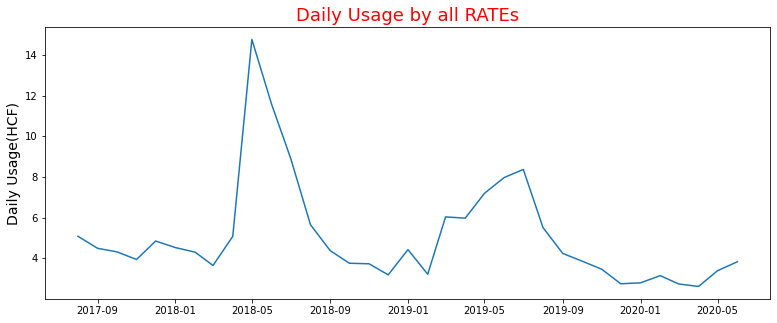

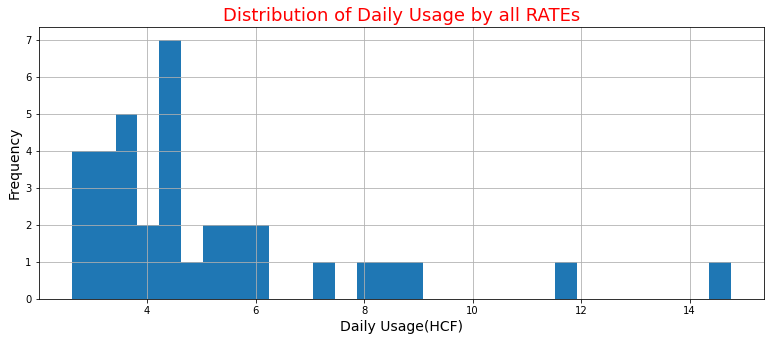

In [9]:
plt.figure(figsize=(13,5))
plt.plot(ts_usage)
plt.ylabel('Daily Usage(HCF)', fontsize= 14)
plt.title('Daily Usage by all RATEs', fontsize=18, color='red')
plt.show()


plt.figure(figsize=(13,5))
ts_usage.hist(bins= 30)
plt.title('Distribution of Daily Usage by all RATEs', fontsize=18, color='red')
plt.xlabel('Daily Usage(HCF)', fontsize= 14)
plt.ylabel('Frequency', fontsize= 14)

plt.show()

**Daily usage by all RATEs doesn't seem to have constant mean and variance over time.**

During exploration, I found different RATE(customer groups) didn't have the same behavior. So, let's analyze each RATE.

# Individual Approach for Modeling

## 2.  Analysis and Transforms - Daily Usage by RATE

In [10]:
#Extract usage of each RATE over the time
ts_COM = data[data.RATE == 'COM'].groupby('month_start')['daily_usage'].sum()
ts_IND = data[data.RATE == 'IND'].groupby('month_start')['daily_usage'].sum()
ts_IRR = data[data.RATE == 'IRR'].groupby('month_start')['daily_usage'].sum()

ts_RDUPLEX = data[data.RATE == 'RDUPLX'].groupby('month_start')['daily_usage'].sum()
ts_RMF = data[data.RATE == 'RMF'].groupby('month_start')['daily_usage'].sum()
ts_RSF = data[data.RATE == 'RSFD'].groupby('month_start')['daily_usage'].sum()


## a) Check Trend
Fitting and predicting Linear Regressor to know if time series usage related to each group has a trend.

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

def decompose(timeseries):
    '''Docompose time series'''
    decomposition = seasonal_decompose(timeseries, model= 'multiplicative')
    rcParams['figure.figsize'] = 15, 8
    decomposition.plot()
    pass
    return decomposition

In [12]:
def check_trend(timeseries, decomposition, groupname):
    '''Plot Automatic decomposed trend, rolling mean with 12 steps, and time independent trend'''
    
    fig = plt.figure(figsize=(15, 7))
    ax1 = plt.subplot2grid((3,1), (0,0))
    ax2 = plt.subplot2grid((3,1), (1,0))
    ax3 = plt.subplot2grid((3,1), (2,0))

    #Plot the trend
    ax1.plot(decomposition.trend)
    ax1.set_title('Automatic Decomposed Trend - {} Group'.format(groupname),fontsize= 16, c='red')

    #Plot moving average
    rolling_mean = timeseries.rolling(window= 13).mean()
    ax2.plot(rolling_mean)
    ax2.set_title('Moving Average-12 steps',fontsize= 16, c='red')


    #Fit a linear regression to find a trend independent from time 
    from sklearn.linear_model import LinearRegression
    X = list(range(len(timeseries)))
    X = np.reshape(X, (len(X),1))

    y = timeseries.values
    lr= LinearRegression()
    lr.fit(X,y)
    trend = lr.predict(X)
    ax3.plot(trend)
    ax3.set_title('Trend(time independent)',fontsize= 16, c='red')


    plt.tight_layout()
    plt.show()

### Decompose daily usage by all customers and check its trend


     All Customer Groups


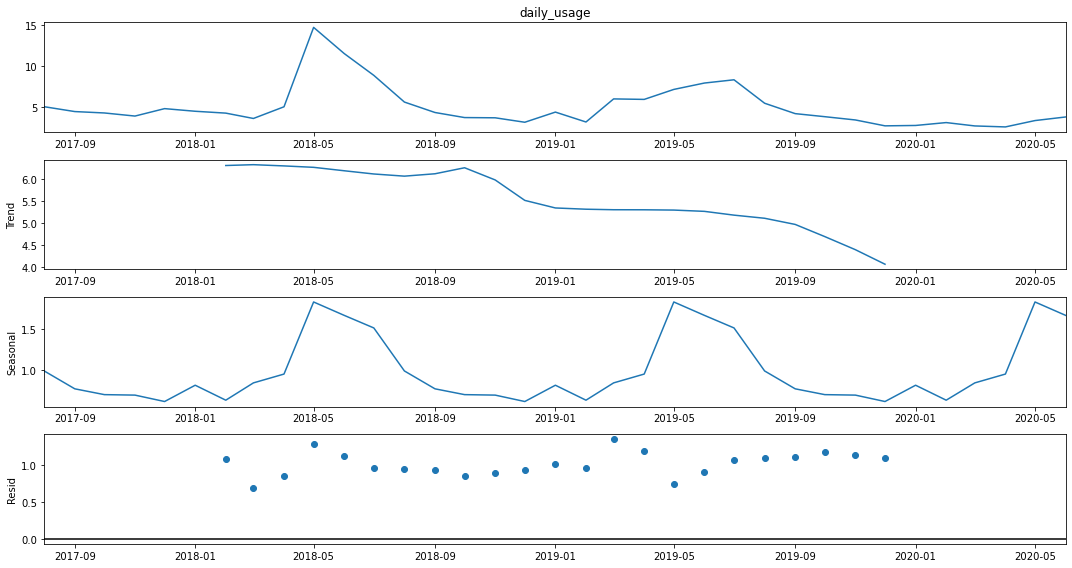

In [13]:
print('\n     All Customer Groups')
total_decomposition= decompose(ts_usage)


     Check Trend - All Customer Groups


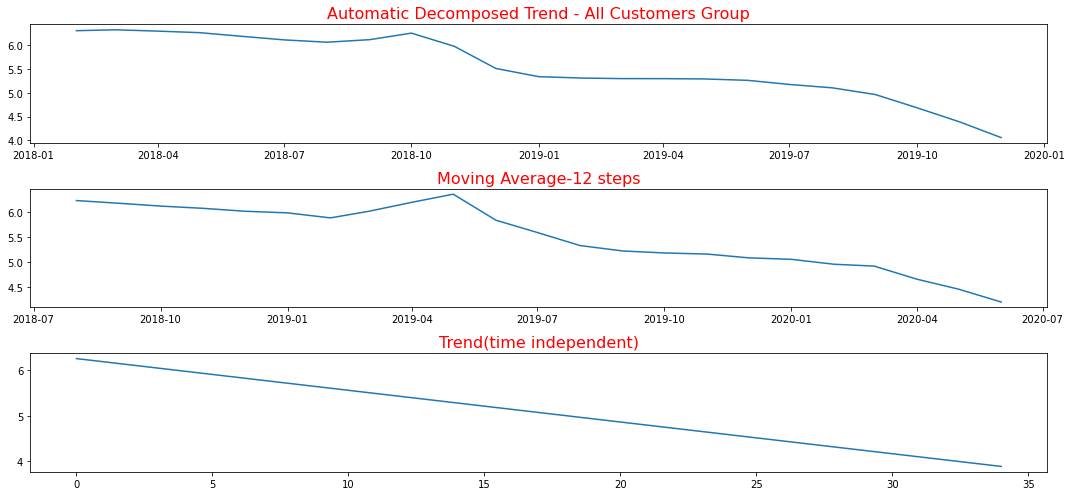

In [14]:
print('\n     Check Trend - All Customer Groups')
check_trend(ts_usage, total_decomposition, 'All Customers')

#### When I fitted linear regression model on daily usage values (independent from time), the result of prediction is relatively close to the automatic decomposed trend. Daily usage doesn't seem to have a trend.

## Does usage of each RATE have a trend?

### a.1 Commercial Group


     Commercial Group


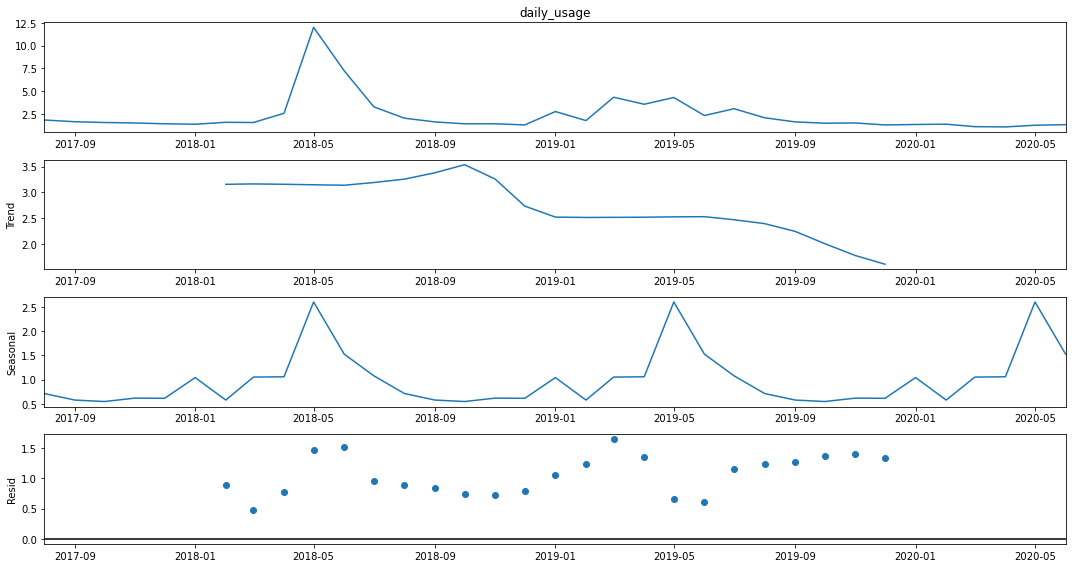

In [15]:
print('\n     Commercial Group')
COM_decomposition= decompose(ts_COM)



     Check Trend - Commercial Group


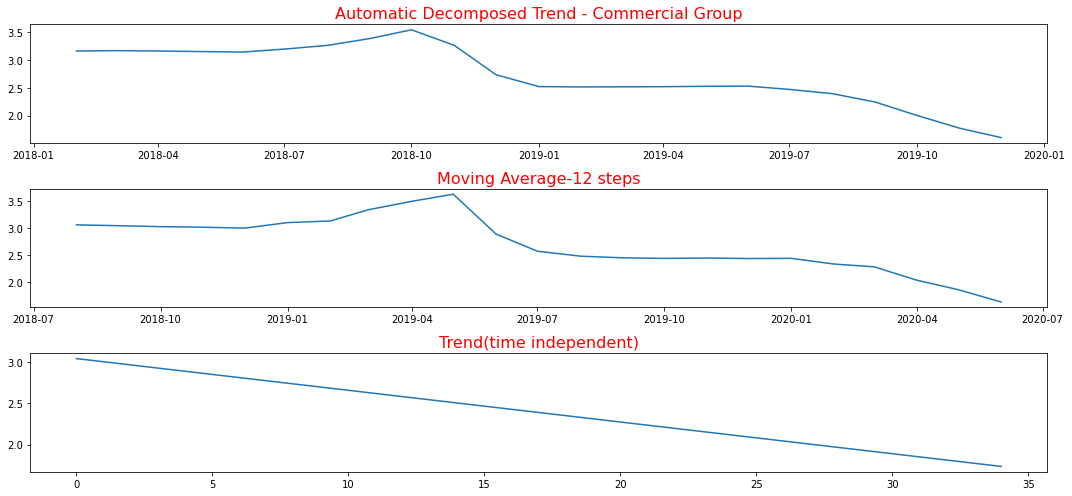

In [16]:
print('\n     Check Trend - Commercial Group')
check_trend(ts_COM, COM_decomposition, 'Commercial')

### a.2  Industrial Group


     Industrial Group


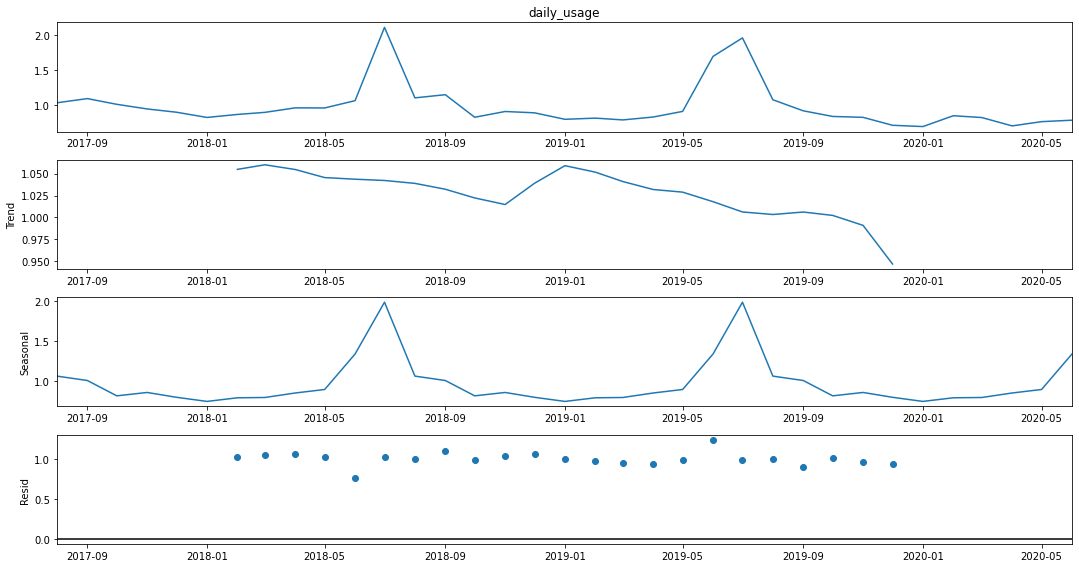

In [17]:
print('\n     Industrial Group')
IND_decomposition= decompose(ts_IND)



     Check Trend - Industrial Group


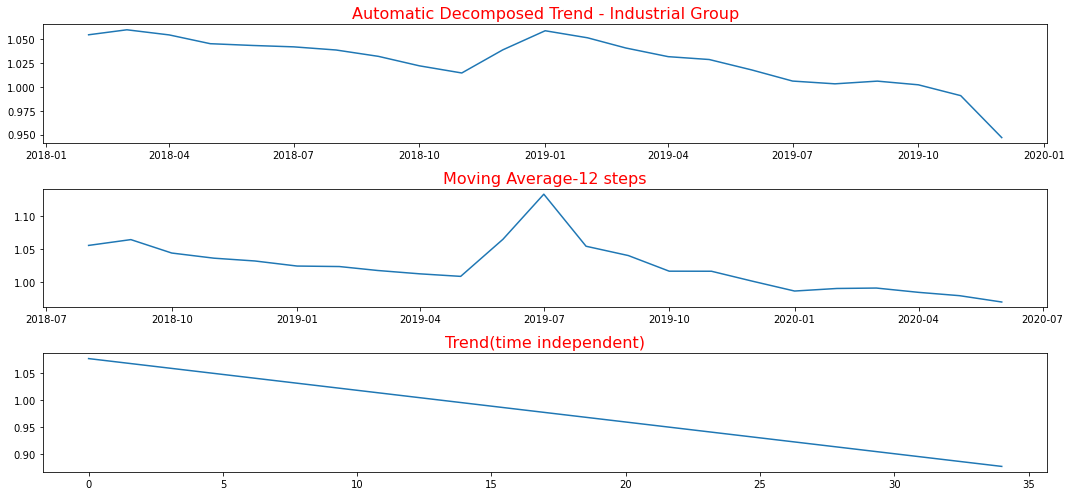

In [18]:
print('\n     Check Trend - Industrial Group')
check_trend(ts_IND, IND_decomposition, 'Industrial')

### a.3 Irrigation Group


     Irrigation Group


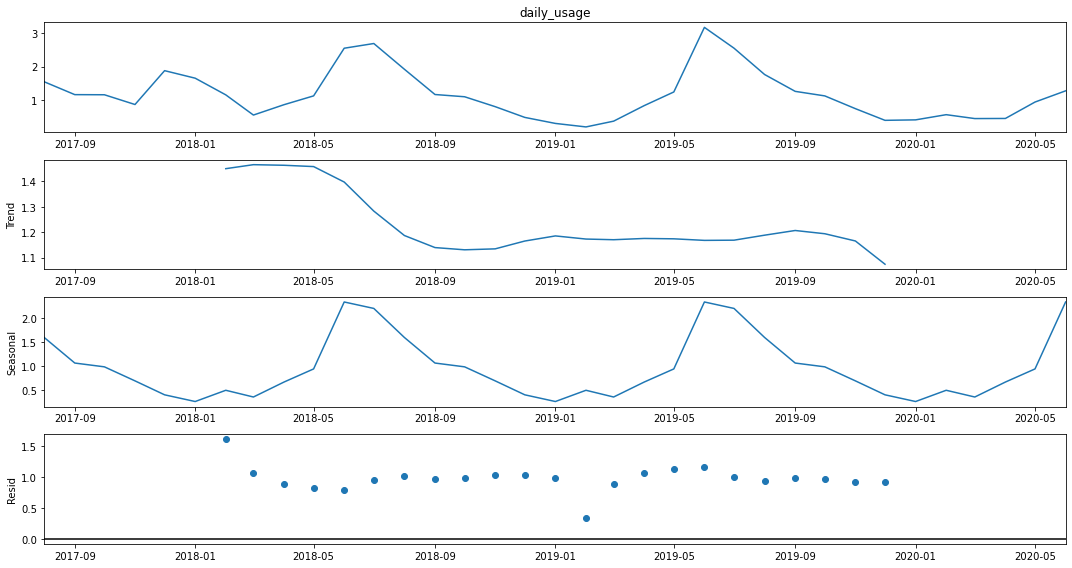

In [19]:
print('\n     Irrigation Group')
IRR_decomposition= decompose(ts_IRR)


     Check Trend - Irrigation Group


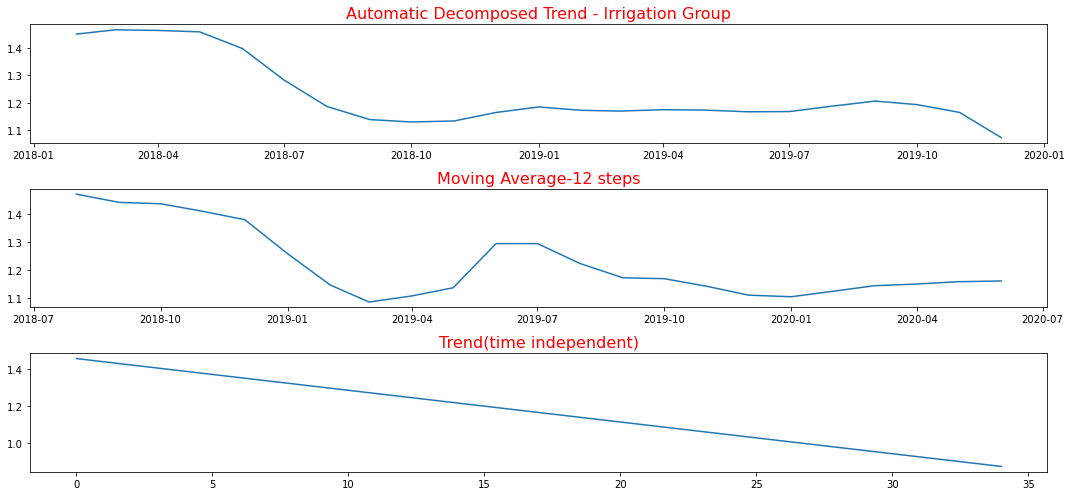

In [20]:
print('\n     Check Trend - Irrigation Group')
check_trend(ts_IRR, IRR_decomposition, 'Irrigation')

### Usage in commercial, industrial and irrigation groups don't have any special trend.

### a.4 Residential - Single Family Group


     Single Family Group


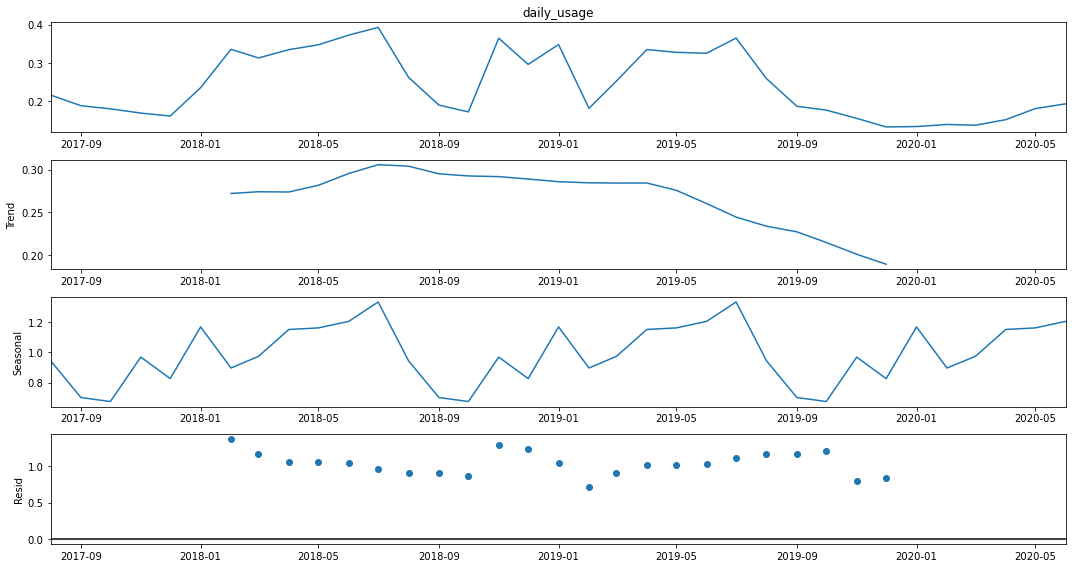

In [21]:
print('\n     Single Family Group')
RSF_decomposition= decompose(ts_RSF)


     Check Trend - Single Family Group


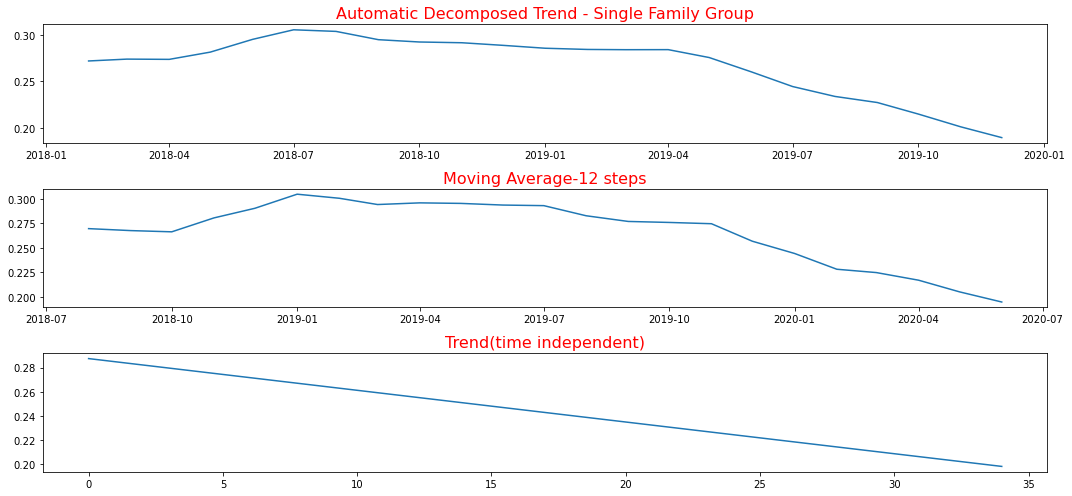

In [22]:
print('\n     Check Trend - Single Family Group')
check_trend(ts_RSF, RSF_decomposition, 'Single Family')

### a.5 Residential - Duplex Group


     Duplex Group


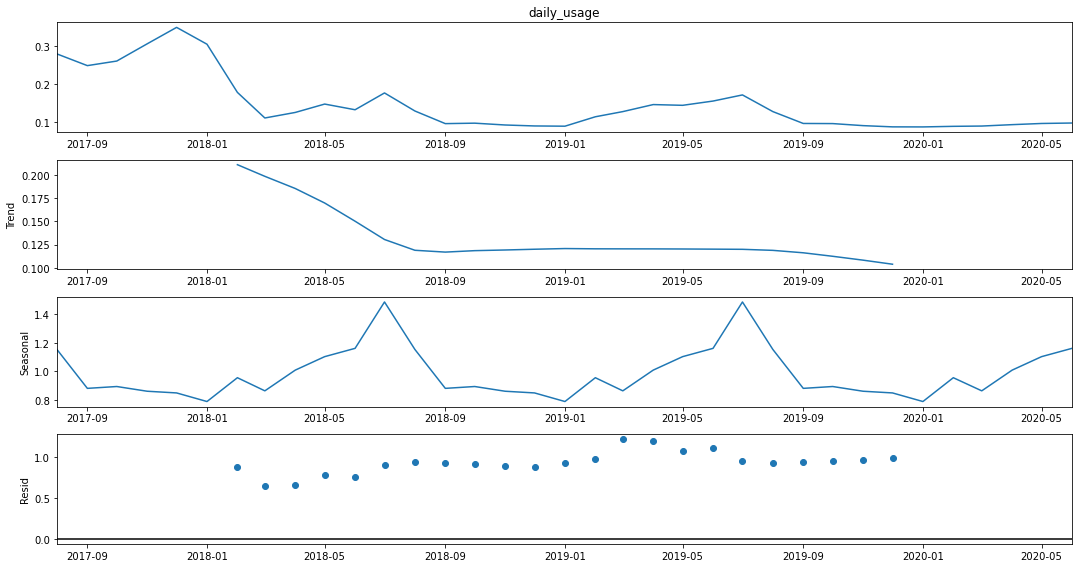

In [23]:
print('\n     Duplex Group')
Duplex_decomposition= decompose(ts_RMF)


     Check Trend - Duplex Group


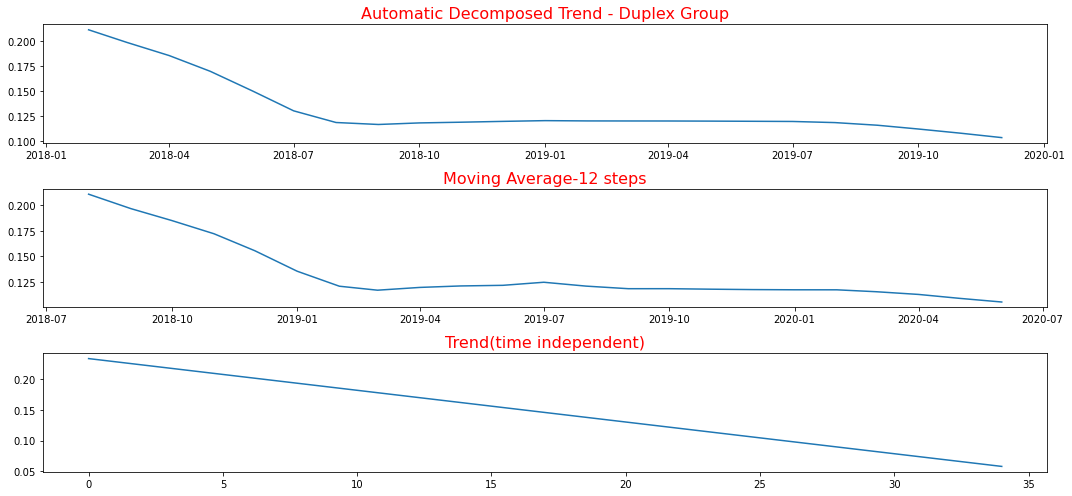

In [24]:
print('\n     Check Trend - Duplex Group')
check_trend(ts_RMF, Duplex_decomposition, 'Duplex')

### a.6 Residential - Multi Family Group


     Multi-Family Group


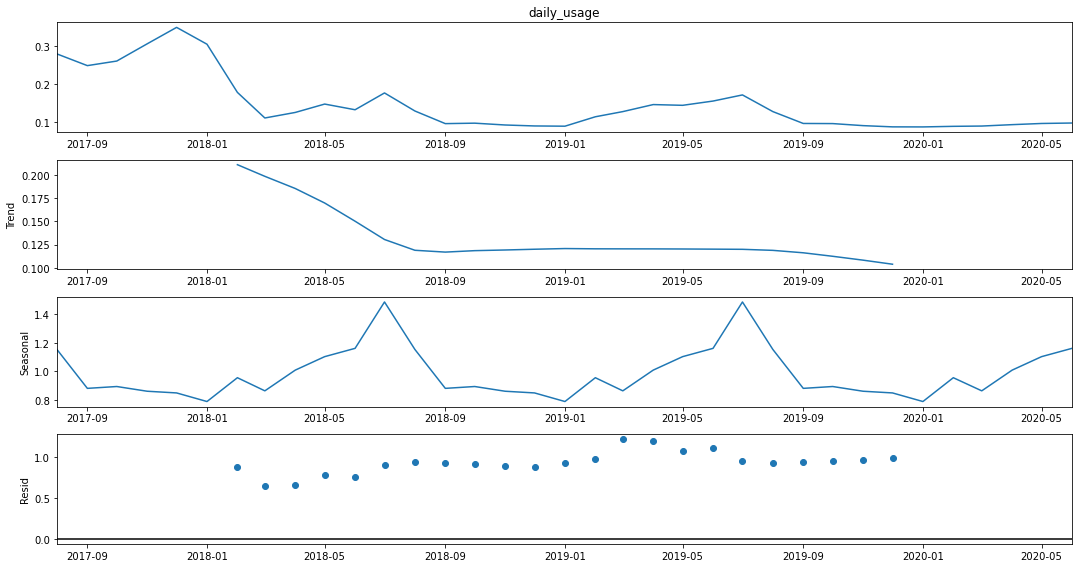

In [25]:
print('\n     Multi-Family Group')
RMF_decomposition= decompose(ts_RMF)


     Check Trend - Multi-Family Group


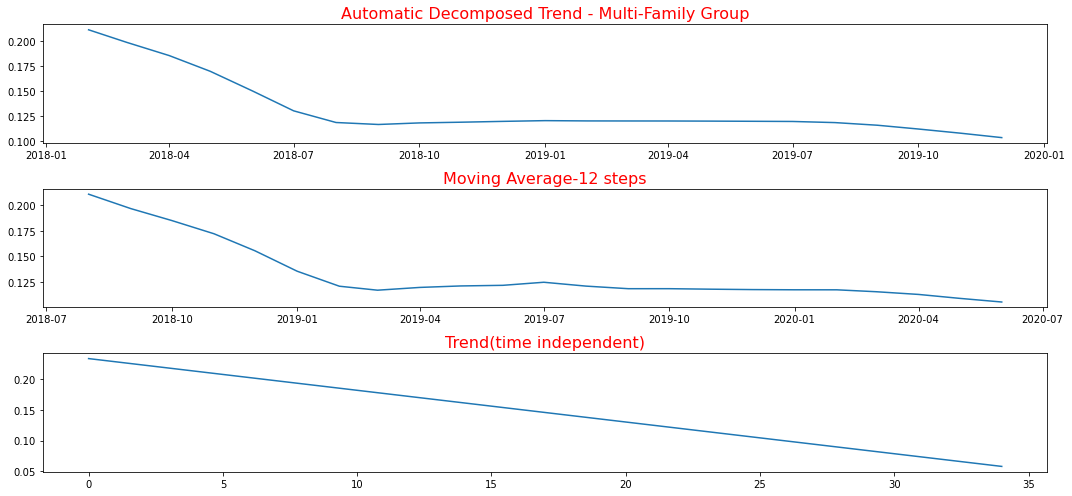

In [26]:
print('\n     Check Trend - Multi-Family Group')
check_trend(ts_RMF, RMF_decomposition, 'Multi-Family')

###  Although all residential customers have a trend with negative slope, Duplex and multi-family groups usage have similar trend but single-family usage has a slightly different trend.

##  b) Check Seasonality
In each year, usage has raised continuously from February to September, then from October to January of next year the usage has decreased. This distinct pattern repeated each year.

Let's fit a polynomial curve to find seasonality of time series.

In [27]:
def check_seasonality(timeseries, groupname):
    
    #Each value on curve has value of x between 0 and 11.
    X = [i%12 for i in range(len(timeseries))]  
    y = timeseries.values
 
    #fit a polynomial curve with degree of 100 on X and y   
    degree = 100
    coef = np.polyfit(X, y, degree)

    #for each x in X, let's find its value on polynomial curve
    curve = []
    for i in range(len(X)):
        y_curve = coef[-1]    #add intercept value
        for d in range(degree):
            y_curve  += (X[i] **(degree-d)) * coef[d]
        curve.append(y_curve)    
    

    #Plot the curve and original avg usage
    plt.figure(figsize= (15,5))
    label = '{} daily usage'.format(groupname)
    plt.plot(timeseries.values, label= label )
    plt.plot(curve, c= 'green', label= 'Polynomial model')


    plt.legend(fontsize=11)
    plt.xlabel('Month',fontsize=13)
    plt.ylabel('Daily Usage (HCF)',fontsize=13)
    plt.title('Polynomial Curve to Find Seasonlity - {}'.format(groupname), color= 'red',fontsize=15)
    plt.show()

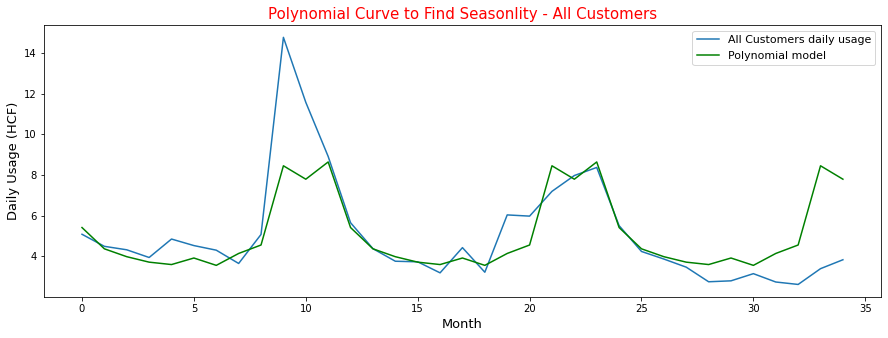

In [28]:
check_seasonality(ts_usage, 'All Customers')

### Daily usage by all customer group didn't follow yearly seasonality from March '20.

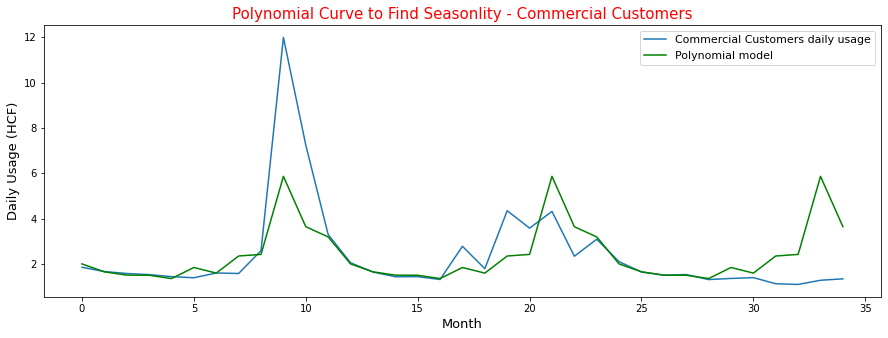

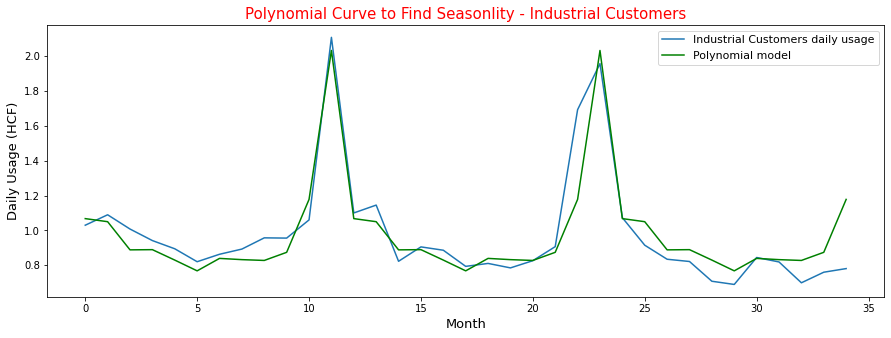

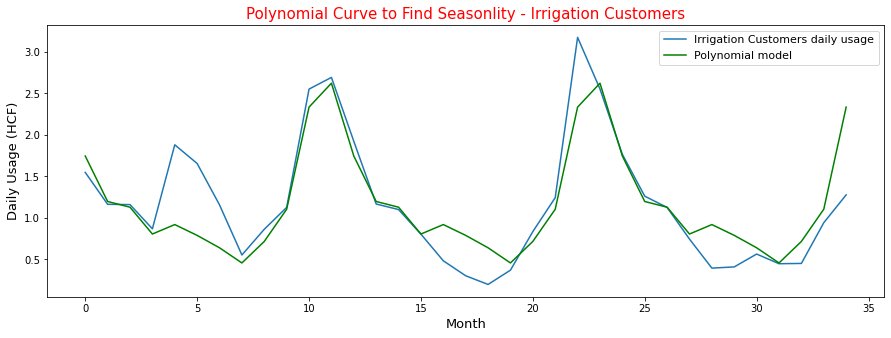

In [29]:
check_seasonality(ts_COM, 'Commercial Customers')
check_seasonality(ts_IND, 'Industrial Customers')
check_seasonality(ts_IRR , 'Irrigation Customers')

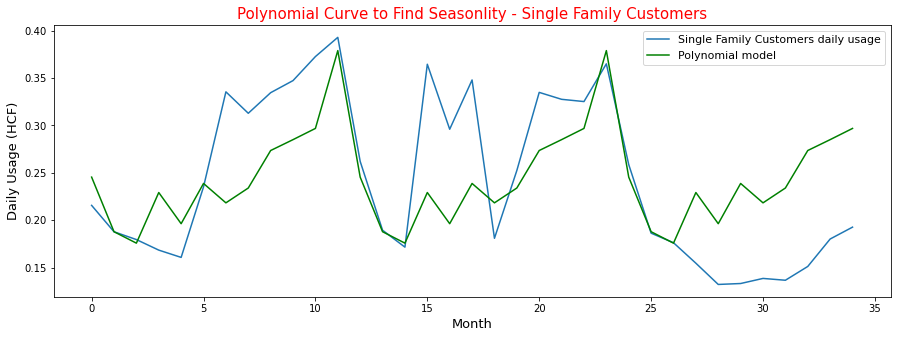

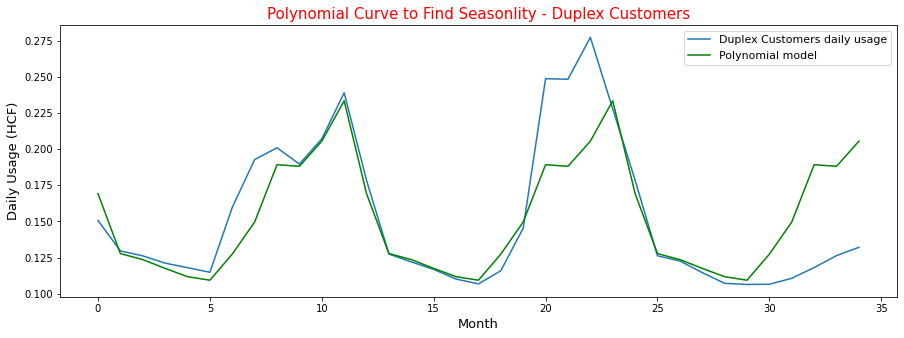

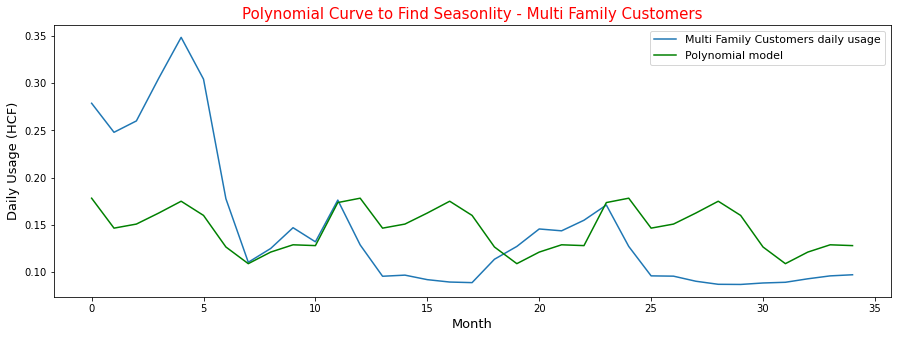

In [30]:
check_seasonality(ts_RSF, 'Single Family Customers')
check_seasonality(ts_RDUPLEX , 'Duplex Customers')
check_seasonality(ts_RMF , 'Multi Family Customers')

### Commercial, single family, duplex, multi family groups didn't follow the seasonality and their usage decreased from March '20.
### Irrigation and industrial group keep the seasonality more in their usage.

## c) Check Noise
Check the distribution and statistics of daily usage. 

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


def check_noise(timeseries , groupname):
    plt.figure(figsize=(18,12))
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))

    #Plot distribution of daily usage values
    ax1.hist(timeseries, bins= 30)
    title = '{} Daily Usage Distribution'.format(groupname)
    ax1.set_title(title, c='red', fontsize=13)
    ax1.set_ylabel('Frequency',fontsize=12)
    ax1.set_xlabel('Daily Usage(HCF)',fontsize=12)

    #Plot autocorrelation
    plot_acf(timeseries, lags=24, ax=ax2)
    ax2.set_title('Autocorrelation', c='red', fontsize=12)
    ax2.set_ylabel('ACF',fontsize=13)


    #plot distribution of std for Moving Average with 12 steps
    ax3.hist(timeseries.rolling(window= 13).mean().dropna(), bins=20)
    ax3.set_title('Distribution of Std of Moving Average with 12 Steps', c='red', fontsize=13)
    ax3.set_ylabel('Frequency',fontsize=13)
    ax3.set_xlabel('Mean of Moving Avg',fontsize=12)

    #plot distribution of std for Moving Average with 12 steps
    ax4.hist(timeseries.rolling(window= 13).std().dropna(), bins=20)
    ax4.set_title('Distribution of Mean of Moving Average with 12 Steps', c='red', fontsize=13)
    ax4.set_ylabel('Frequency',fontsize= 13)
    ax4.set_xlabel('Std of Moving Avg',fontsize=12)


    plt.show()

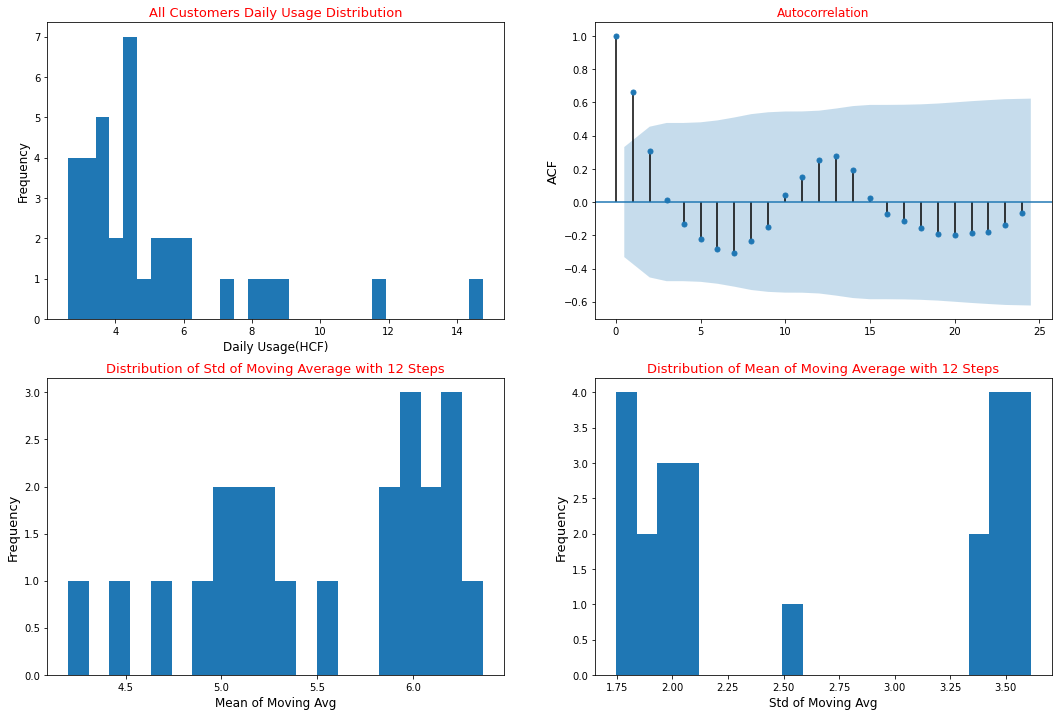

In [32]:
check_noise(ts_usage , 'All Customers')

### Daily usage is not a white noise for three reasons:

#### 1) Daily usage doesn't have a Gaussian distribution,
#### 2) Mean and variance are not constant with time, and,
#### 3) Daily usage values are not independent, they are correlated with many values in the latter months (Autocorrelation at many lags are not zero), 

**So the past will help me forecast the future.**


### Question: Is the daily usage in each RATE a white noise?

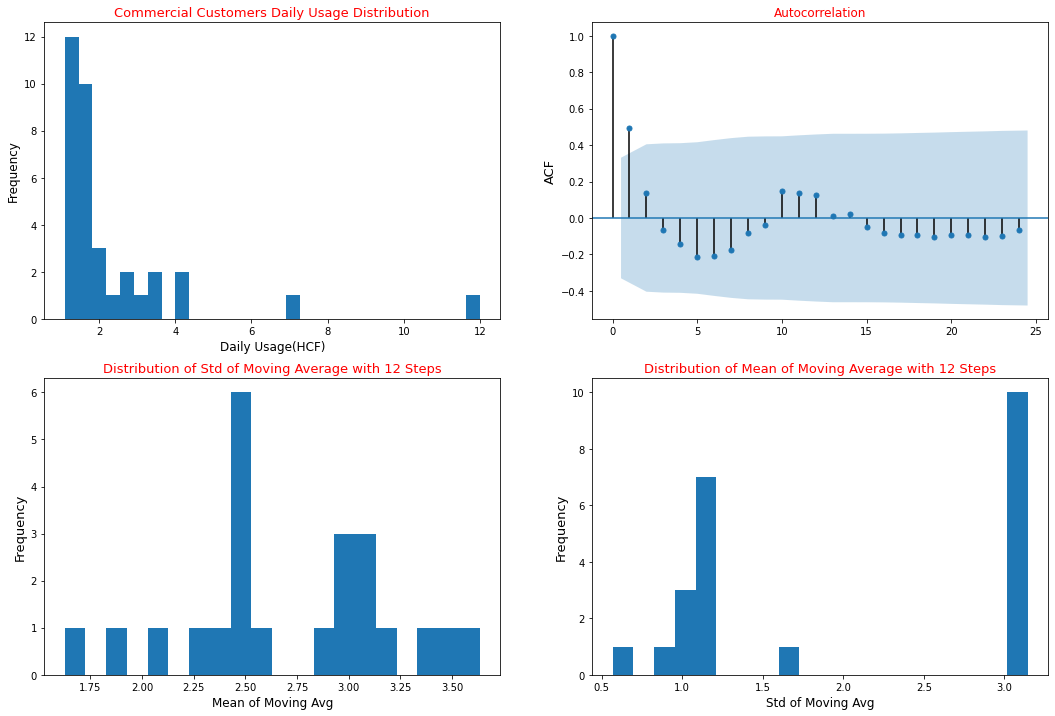

In [33]:
check_noise(ts_COM , 'Commercial Customers')

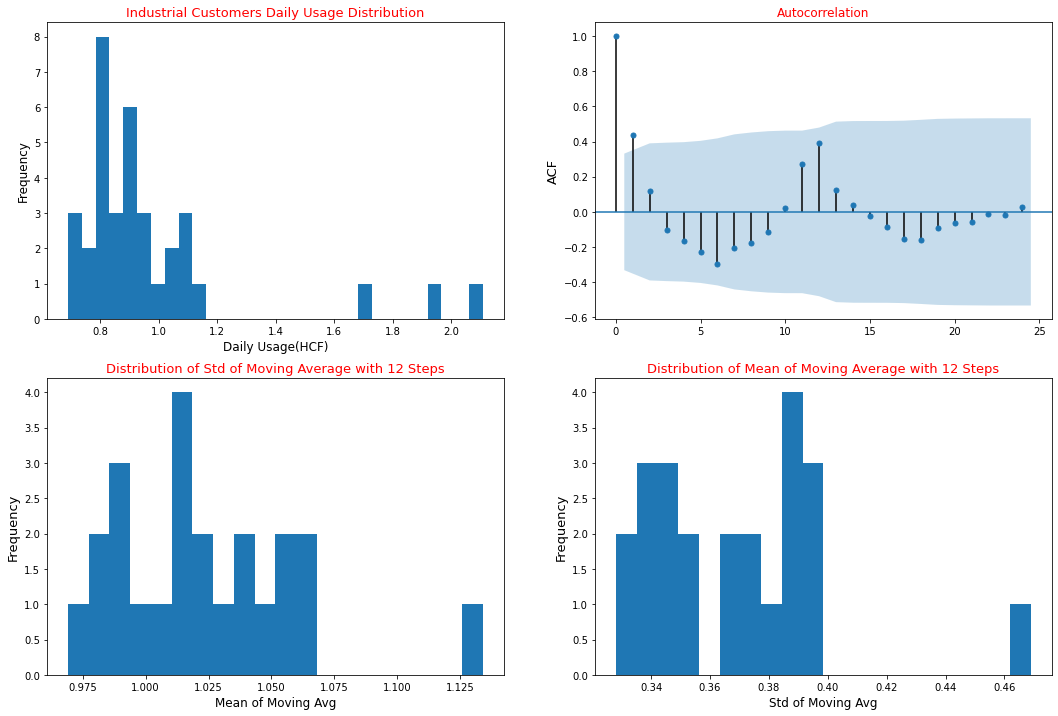

In [34]:
check_noise(ts_IND , 'Industrial Customers')

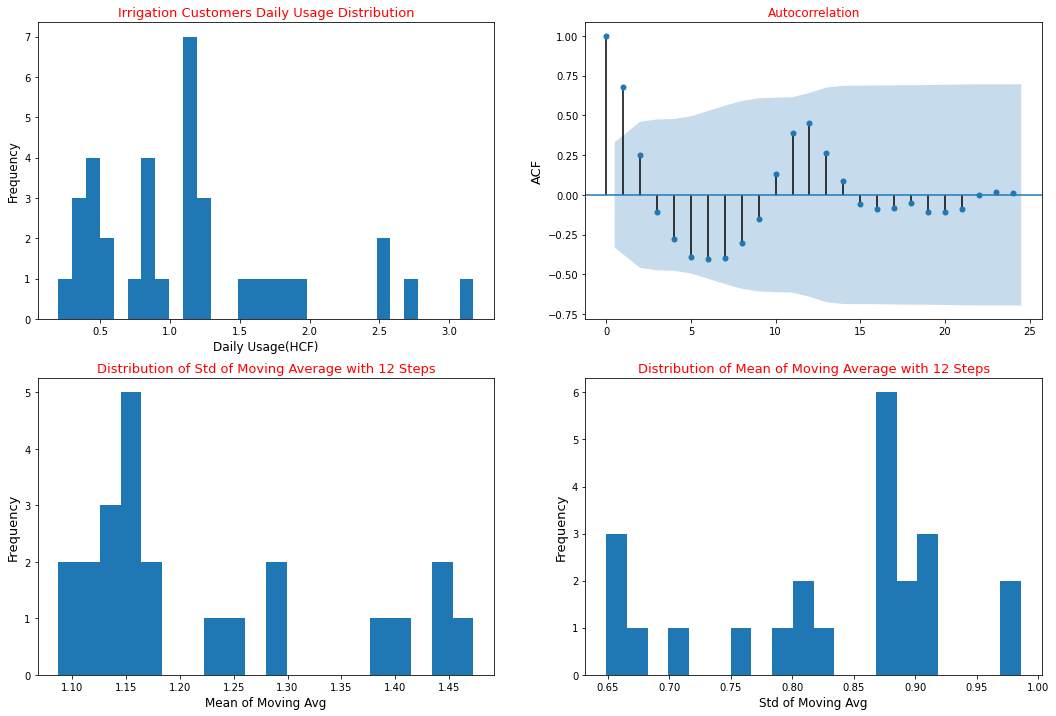

In [35]:
check_noise(ts_IRR , 'Irrigation Customers')

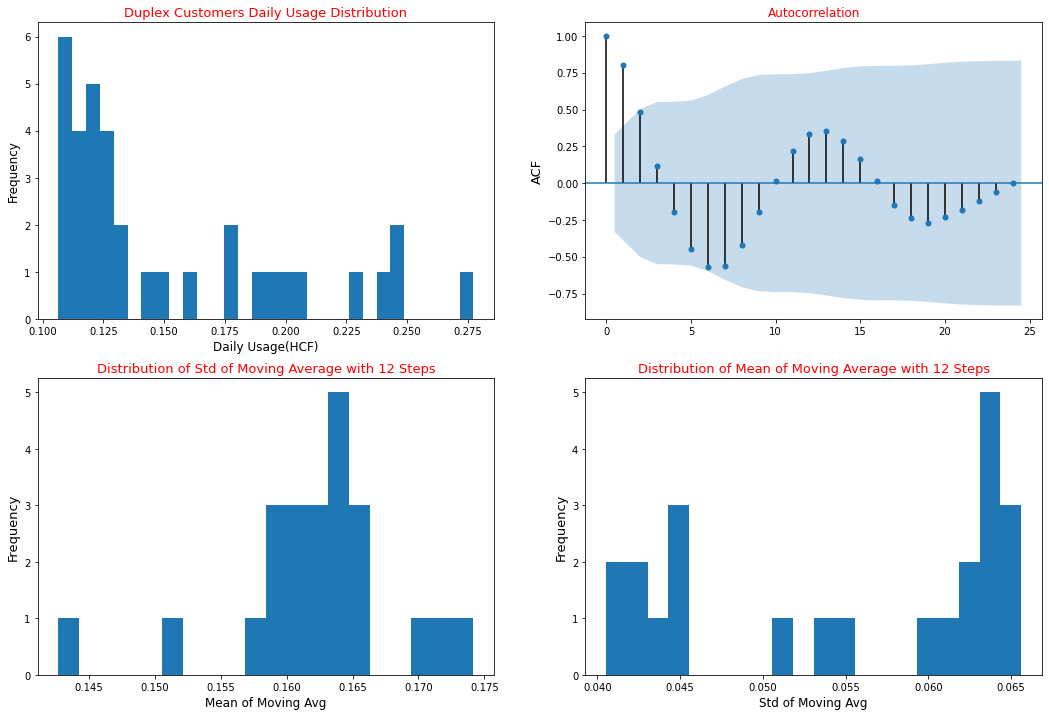

In [36]:
check_noise(ts_RDUPLEX , 'Duplex Customers')

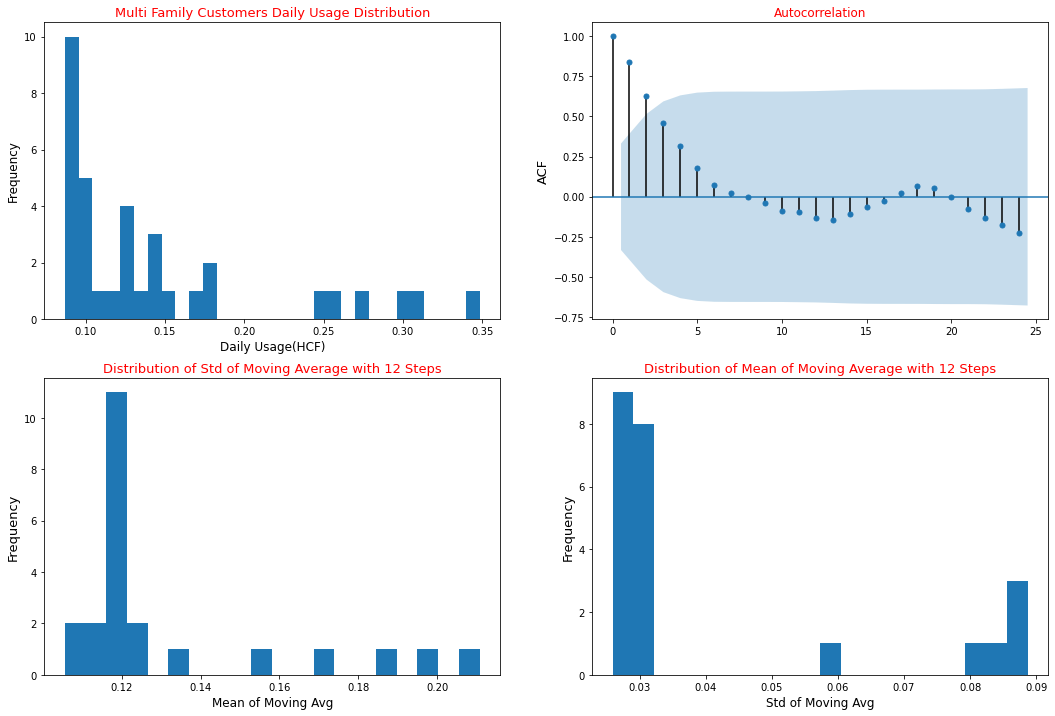

In [37]:
check_noise(ts_RMF , 'Multi Family Customers')

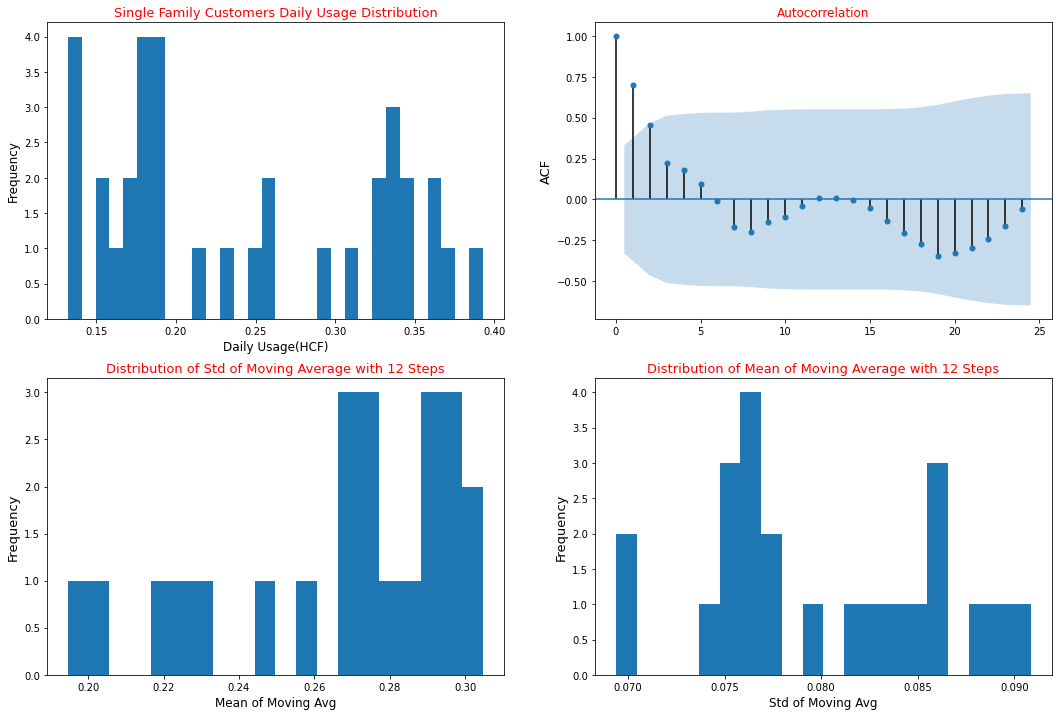

In [38]:
check_noise(ts_RSF , 'Single Family Customers')

### Daily usage in each RATE is not a white noise, because:
#### * Mean and variance are not constant over time, and,
#### * Daily usage values are not independent, they are correlated with many values in the latter months (Autocorrelation at many lags are not zero), 

## d) Stationary
Check stationary of time series using Augmented Dicky-Fuller test (ADF)

### Is the time series of daily usage stationary or random walk?
#### Null hypothesis (H0) : the time series follows a random walk (There is a unit root)

#### Alternative hypothesis (H1) : The time series is stationary

In [39]:
#Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller


   
def adf_test(timeseries):  
    '''Perform Dicky-Fuller test'''
    print('\nResults of Dickey-Fuller Test:')
        
    # Set autolag as BIC, so the number of lags is chosen to minimize the corresponding information criterion
    df_test = adfuller(timeseries, autolag= 'BIC') 


    df_output = pd.Series(df_test[0:4] , index= ['test statistic', 'p-value', '# Lags Used','# Observation Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value {}'.format(key)] = value
    print(df_output)   

In [40]:
print('All Customers Daily Usge')
adf_test(ts_usage)

All Customers Daily Usge

Results of Dickey-Fuller Test:
test statistic        -2.515085
p-value                0.111847
# Lags Used            0.000000
# Observation Used    34.000000
Critical Value 1%     -3.639224
Critical Value 5%     -2.951230
Critical Value 10%    -2.614447
dtype: float64


### test statistic is not smaller than critical values at any significance levels, in addition p-value is not small. Time series of daily usage by all RATE is not stationary.

## Is time series of daily usage of different RATE is stationary?

In [41]:
print('-----Commercial Daily Usge')
adf_test(ts_COM)

print('\n-----Industrial Daily Usge')
adf_test(ts_IND)

print('\n-----Irrigation Daily Usge')
adf_test(ts_IRR)

print('\n-----Duplex Daily Usge')
adf_test(ts_RDUPLEX)

print('\n-----Multi-Family Daily Usge')
adf_test(ts_RMF)

print('\n-----Single-Family Daily Usge')
adf_test(ts_RSF)

-----Commercial Daily Usge

Results of Dickey-Fuller Test:
test statistic        -3.251336
p-value                0.017199
# Lags Used            0.000000
# Observation Used    34.000000
Critical Value 1%     -3.639224
Critical Value 5%     -2.951230
Critical Value 10%    -2.614447
dtype: float64

-----Industrial Daily Usge

Results of Dickey-Fuller Test:
test statistic        -3.491720
p-value                0.008202
# Lags Used            0.000000
# Observation Used    34.000000
Critical Value 1%     -3.639224
Critical Value 5%     -2.951230
Critical Value 10%    -2.614447
dtype: float64

-----Irrigation Daily Usge

Results of Dickey-Fuller Test:
test statistic        -3.353235
p-value                0.012660
# Lags Used            1.000000
# Observation Used    33.000000
Critical Value 1%     -3.646135
Critical Value 5%     -2.954127
Critical Value 10%    -2.615968
dtype: float64

-----Duplex Daily Usge

Results of Dickey-Fuller Test:
test statistic        -2.897859
p-value         

###  Daily usage of different RATEs are not stationary at 1% significance level.
#### Commercial, Irrigation and industrial usage are stationary at 5% significance level but not at 1% significance level.


## e) Make daily usage of different RATE stationary

### Testing for stationarity with KPSS
Time series dataset is stationary if its statistical features don't change over time (**constant mean, variance, and covariance**)

One of the most common ways to test for stationarity is the **KPSS test:**

#### The Null hypothesis(H0): the time series data in question is stationary;

#### Alternate Hypothesis(H1): The series has a unit root (series is not stationary).

If the p-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [42]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print('KPSS Test Result:')
    kpsstest = kpss(timeseries, regression= 'c', nlags= 'auto')
    
    kpss_output = pd.Series(kpsstest[0:3], index= ['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output ['Critical Value (%s)'%key] = value
    
    print(kpss_output)

In [43]:
print('-----Commercial Daily Usge - Difference order 1')
diff1_COM = ts_COM.diff(1).dropna()
kpss_test(diff1_COM)

print('\n-----Industrial Daily Usge - Difference order 1')
diff1_IND = ts_IND.diff(1).dropna()
kpss_test(diff1_IND)

print('\n-----Irrigation Daily Usge - Difference order 1')
diff1_IRR = ts_IRR.diff(1).dropna()
kpss_test(diff1_IRR)

print('\n-----Duplex Daily Usge - Difference order 1')
diff1_RDUPLEX = ts_RDUPLEX.diff(1).dropna()
kpss_test(diff1_RDUPLEX)

print('\n-----Multi-Family Daily Usge - Difference order 1')
diff1_RMF = ts_RMF.diff(1).dropna()
kpss_test(diff1_RMF)

print('\n-----Single-Family Daily Usge - Difference order 1')
diff1_RSF = ts_RSF.diff(1).dropna()
kpss_test(diff1_RSF)

-----Commercial Daily Usge - Difference order 1
KPSS Test Result:
Test Statistic           0.102324
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

-----Industrial Daily Usge - Difference order 1
KPSS Test Result:
Test Statistic           0.090953
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

-----Irrigation Daily Usge - Difference order 1
KPSS Test Result:
Test Statistic           0.050217
p-value                  0.100000
Lags Used                0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

-----Duplex Daily Usge - Difference orde

### For each RATE, usage difference of order one became staionary.

In [44]:
def check_stationary_differenced(timeseries, groupname):
    
    plt.figure(figsize=(15,10))
    ax1= plt.subplot2grid((2,2), (0,0), colspan=2)
    ax2 = plt.subplot2grid((2,2), (1,0))
    ax3 = plt.subplot2grid((2,2), (1,1))
  
    
    ax1.plot(timeseries, label = 'Differenced')
    ax1.plot(timeseries.rolling(7).mean(), label='Rolling Mean(7)')
    ax1.plot(timeseries.rolling(7).std(), label = 'Rolling Std(7)')
    ax1.set_title('{}'.format(groupname), color='red', fontsize=17)
    ax1.set_ylabel('Daily Usage(HCF)', fontsize=14)
    ax1.legend(fontsize=14)
     
    plot_acf(timeseries,ax= ax2)
    ax2.set_title('Autocorrelation-{}'.format(groupname), color='red', fontsize=12)
    ax2.set_xlabel('Lag', fontsize=14)
    ax2.set_ylabel('ACF', fontsize=14)


    plot_pacf(timeseries,ax= ax3)
    ax3.set_title('Partial Autocorrelation-{}'.format(groupname), color='red', fontsize=12)
    ax3.set_xlabel('Lag', fontsize=14)
    ax3.set_ylabel('PACF', fontsize=14)
   

    plt.tight_layout()
    plt.show()


#### Commercial Group

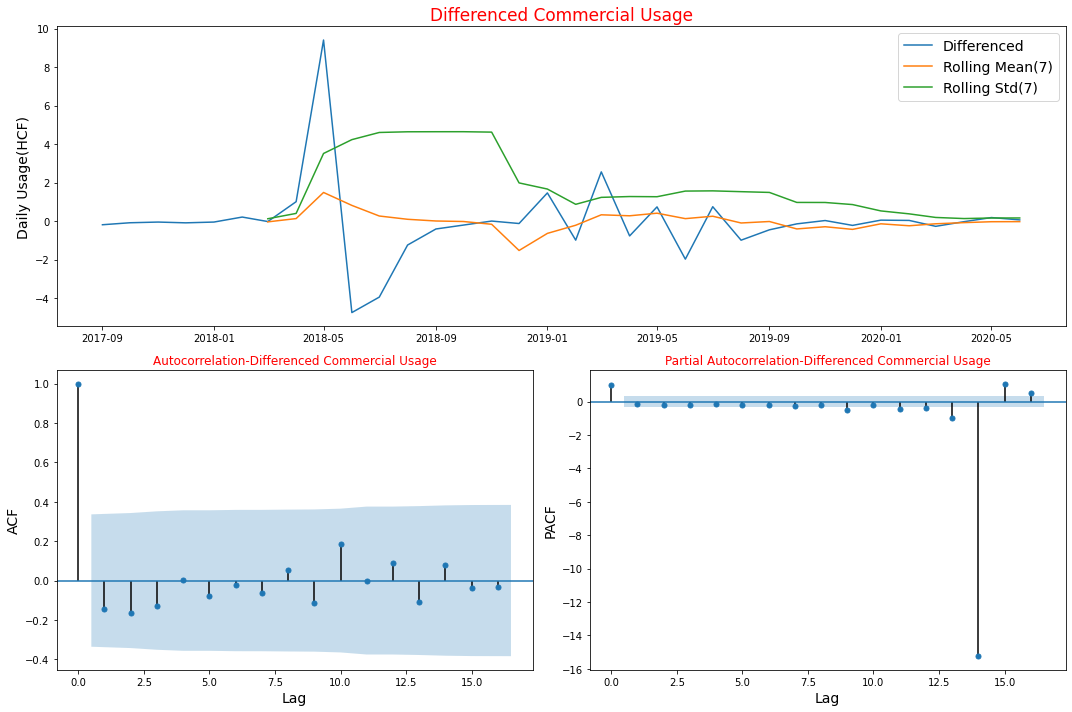

In [45]:
#Plot ACF and PACF for differenced daily usage 
check_stationary_differenced(diff1_COM, 'Differenced Commercial Usage')

#### Industrial Group

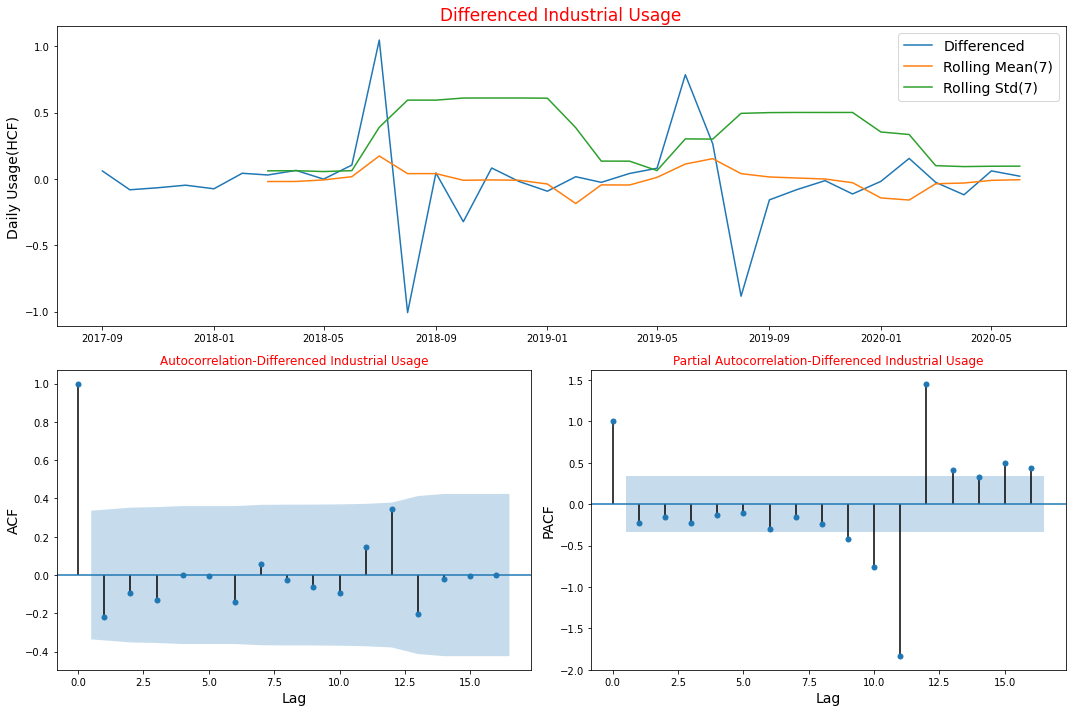

In [46]:
check_stationary_differenced(diff1_IND, 'Differenced Industrial Usage')


#### Irrigation Group

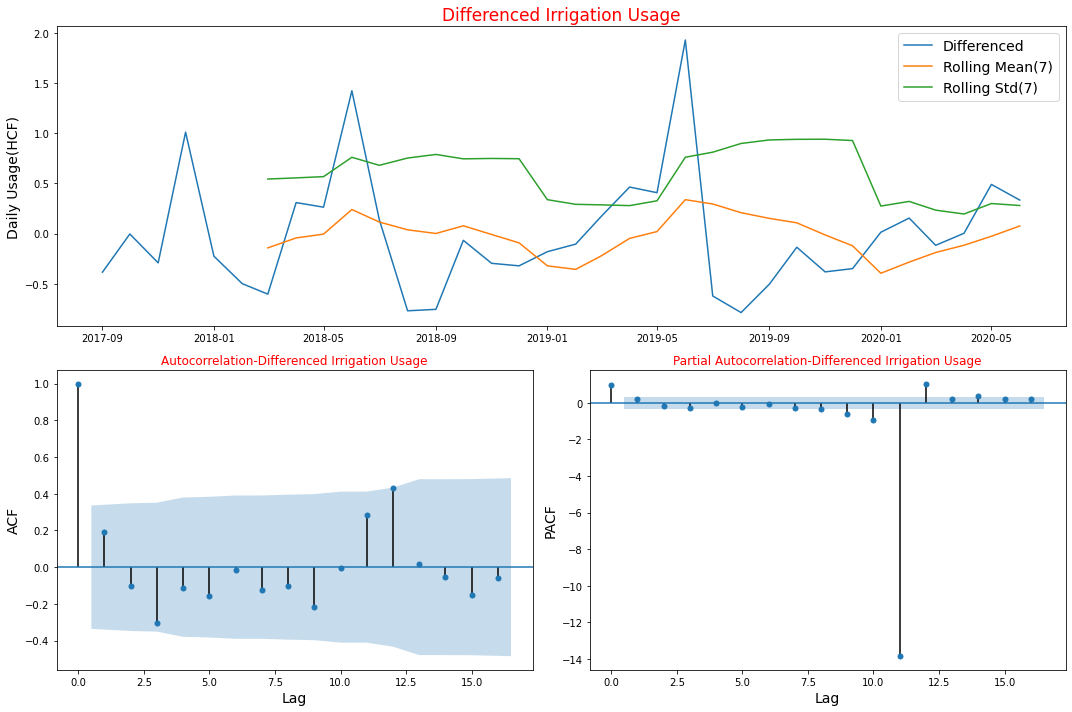

In [47]:
check_stationary_differenced(diff1_IRR, 'Differenced Irrigation Usage')


#### Duplex Group

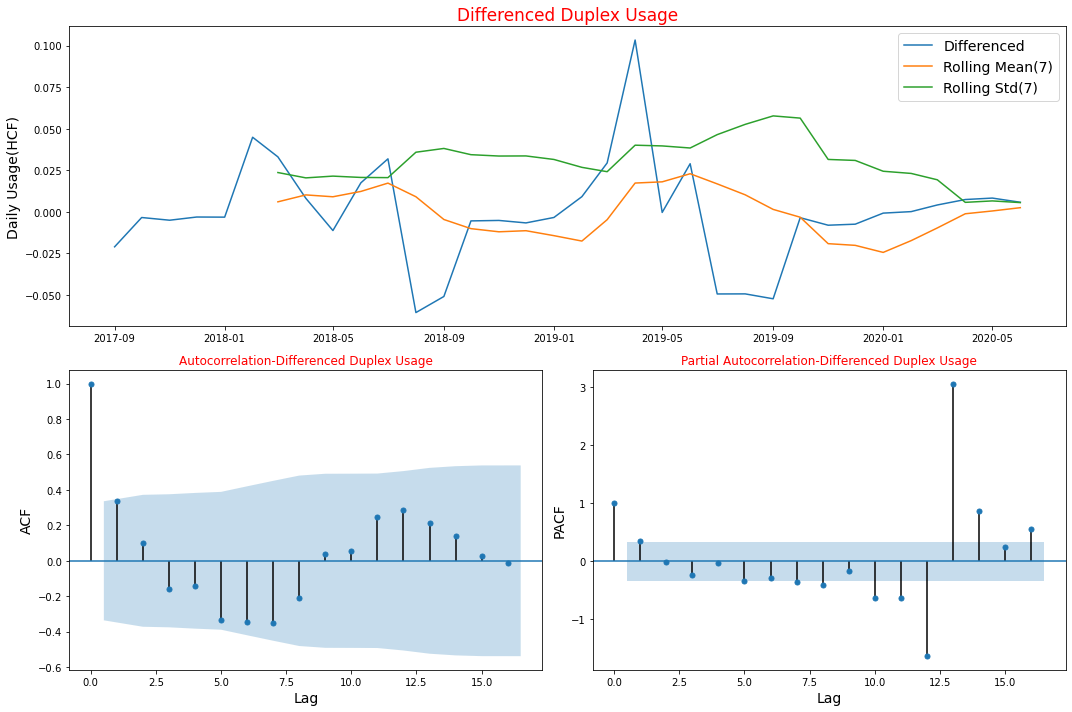

In [48]:
check_stationary_differenced(diff1_RDUPLEX, 'Differenced Duplex Usage')


#### Multi-Family Group

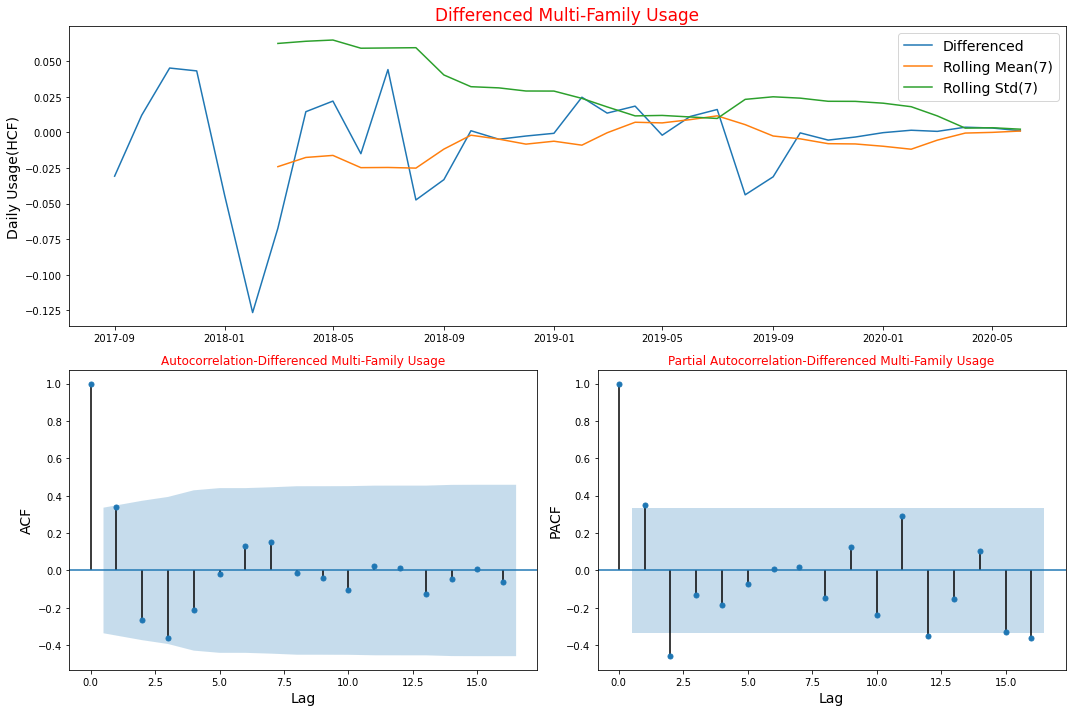

In [50]:
check_stationary_differenced(diff1_RMF, 'Differenced Multi-Family Usage')


#### Single-Family Group

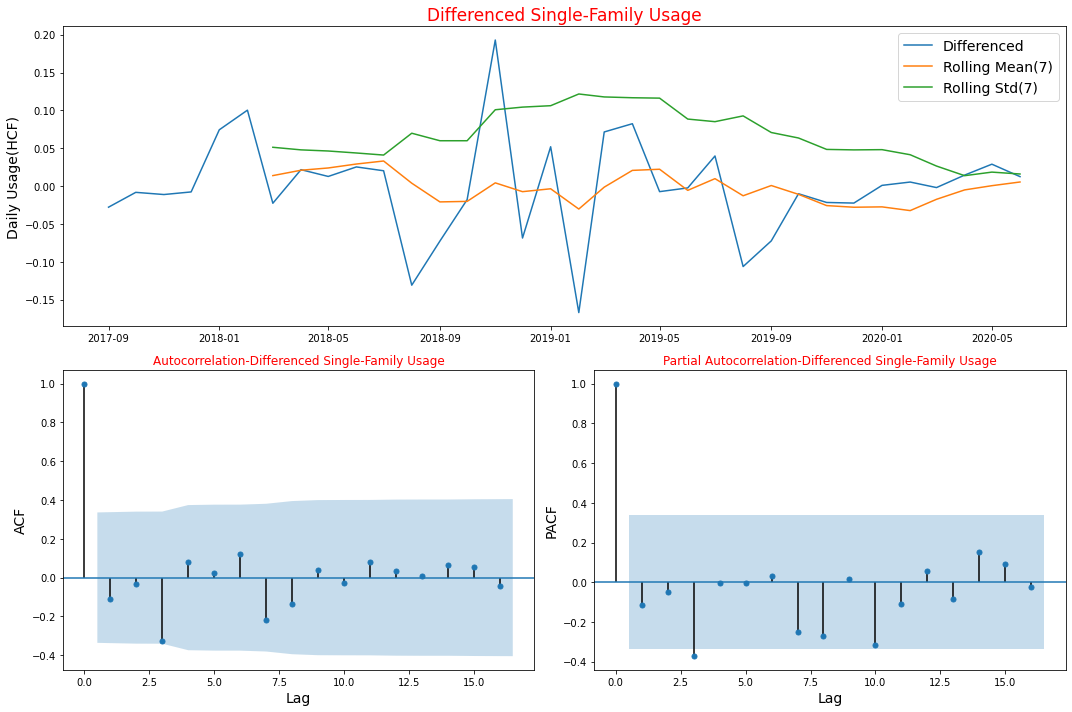

In [51]:
check_stationary_differenced(diff1_RSF, 'Differenced Single-Family Usage')

## 3.  Modeling for each RATE

## 3.1. Univariant time series forecasting

#### To compare the optimal models, the following measurements are calculated for each one:
* root-mean-square error (RMSE)
* mean absolute error(MAE)
* mean absolute percentage error(MAPE)
* r2_score: Unlike most other scores, R^2 score may be negative (it need not actually be the square of a quantity R).

In [52]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


def mean_absolute_percentage_error(y_true, y_pred):
    '''calculae MAPE'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def evaluation(y_actual, y_pred):
    '''calculate evaluation metrics'''
    rmse = round(np.sqrt(mean_squared_error(y_actual, y_pred)),3)
    mae = round(mean_absolute_error(y_actual, y_pred),3)
    mape = round(mean_absolute_percentage_error(y_actual, y_pred),2)
    r2 = round(np.corrcoef(y_actual, y_pred)[0,1],2)
  
    return rmse,mae,mape,r2


### Simple Exponential Smoothing Model (SES)
Model is suitable for data without trend or seasonality. SES model calculates the forecasting data using weighted averages, an exponentially weighted linear function of observations at prior time steps. 

Model uses the smoothing parameter (0<α<1) to determine the smoothing level:
* When α = 0, the forecasts are equal to the average of the historical data. 
* When α = 1, the forecasts will be equal to the value of the last observation.


#### Y^(t+1) = αY + (1−α) Y^(t)


I use the auto-optimization approach which gives the lowest error.

source: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/


In [53]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

def SES(timeseries):
    
    # Needs to be an integer because it is later used as an index
    split= int(len(timeseries) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = timeseries[0:split], timeseries[split:len(timeseries)]
    past=[x for x in train]

    
    y_pred= []
    for i in range(len(test)):                  
        SES = SimpleExpSmoothing(past)
        SES_fitted = SES.fit()
        #predict only next month
        y_pred.append(SES_fitted.predict(start=len(past), end=len(past)).item()) 
        past.append(test[i])
            
    #extract the smoothing level
    alpha = SES_fitted.params['smoothing_level'].round(2)
    metrics= evaluation(test, y_pred)
    
    return alpha, metrics

### Holt Winter’s Exponential Smoothing (HWES)

Triple Exponential Smoothing (HWES) supports both seasonality and trend. 

* Nature of the trend can be set as additive, multiplicative, or none,
* Nature of the seasonality  can be set additive, multiplicative, or none

    * Additive: y(t) = Trend + Seasonal + Random
    
      Seasonal changes in the data stay roughly the same over time and don’t fluctuate in relation to the overall data.
    * Multiplicative: y(t) = Trend * Seasonal * Random

       The seasonal variation changes in relation to the overall changes in the data. So, if the data is trending upward, the  
       seasonal differences grow proportionally as well.
       
       
* dampening of the trend or not

     The trend dampening factor is a number that is multiplied by the trend value (growth rate) when the forecasting value.



Model has **hyperparameters** that control the nature of the exponential performed for the series, trend, and seasonality:

* smoothing_level (0<α<1): the smoothing coefficient for the level.

* smoothing_slope (0<β*<1): the smoothing coefficient for the trend.

* smoothing_seasonal (γ): the smoothing coefficient for the seasonal component.

* damping_slope (ϕ): the coefficient for the damped trend.


Level :    ℓx=α(yx−sx−L)+(1−α)(ℓx−1+bx−1)
Trend :    bx=β(ℓx−ℓx−1)+(1−β)bx−1
Seasonal : sx=γ(yx−ℓx)+(1−γ)sx−L
Forecast:  y^x+m=ℓx+mbx+sx−L+1+(m−1)


source: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/





In [54]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def HWES_model(timeseries):
    # Needs to be an integer because it is later used as an index
    split= int(len(timeseries) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = timeseries[0:split], timeseries[split:len(timeseries)]
    past=[x for x in train]

    
    y_pred= []
    
    for i in range(len(test)):
        ES = ExponentialSmoothing(past)
        ES_fitted = ES.fit()
        #predict only next month
        y_pred.append(ES_fitted.predict(start=len(past), end=len(past)).item()) 
        past.append(test[i])
   
    params = ES_fitted.params
    smoothing_level = params['smoothing_level'].round(2)
    smoothing_slope = params['smoothing_slope'].round(2)
    smoothing_seasonal = params['smoothing_seasonal'].round(2)
    damping_slope = params['damping_slope']
    
    
    params = smoothing_level,smoothing_slope,smoothing_seasonal,damping_slope
    metrics= evaluation(test, y_pred)
    return params, metrics

### Model Selection Criterion: BIC and AIC

#### BIC and AIC have similar behaviour so that they penalise models for having too many parameters and prevent from overfitting. The BIC penalizes additional model orders more than AIC and so the BIC will sometimes suggest a simpler model. 
The AIC and BIC will often choose the same model, but when they don't we will have to make a choice. If our goal is to identify good predictive models, we should use AIC. However if our goal is to identify a good explanatory model, we should use BIC.
BIC deals with the trade-off between the goodness of fit of the model and the complexity of the model itself.

#### Bayesian Information Criterion: If we take the likelihood function for a statistical model, which has k parameters (model degrees of freedom), and L maximises the likelihood, then the Bayesian Information Criterion is given by:

#### BIC = -2 * Log(L) + k Log(n)

Where  is the number of data points in the time series.


#### AIC = -2 * Log(L) + 2 * k

AIC does not depend directly on sample size. 


#### AIC presents the danger that it might overfit, whereas BIC presents the danger that it might underfit, simply in virtue of how they penalize free parameters (2*k in AIC; ln(N)*k in BIC). 

Source: https://stats.stackexchange.com/questions/577/is-there-any-reason-to-prefer-the-aic-or-bic-over-the-other

AIC and BIC can have negative values, and positive values don't matter.


### Autoregressive Model (AR) 
The method models the next step in the sequence as a linear function of the observations at prior time steps.


**Parameter of the model:**

Number of AR terms(p) is the number of lags of dependent variable(past values). For instance if p is 3, the predictors for x(3) are 
x(1) and x(2).

The trend to include in the model:

    ‘n’ - No trend.

    ‘c’ - Constant only.

    ‘t’ - Time trend only.

    ‘ct’ - Constant and time trend.

In [55]:
from statsmodels.tsa.ar_model import AutoReg

def AutoReg_model(timeseries, p, trd, seasonal):
    # Needs to be an integer because it is later used as an index
    split= int(len(timeseries) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = timeseries[0:split], timeseries[split:len(timeseries)]
    past=[x for x in train]
    
    
    #fit different model
    for i in range(len(test)): 
        model = AutoReg(past, lags= p, trend= trd, seasonal= seasonal, period=12)
        model_fit = model.fit()
        past.append(test[i])
            
          
    return (trd, p, seasonal, model_fit.aic, model_fit.bic)

In [56]:
def evaluate_AR_model(timeseries):
    '''Tuning hyper parameters to fit model with the lowest AIC and lowest BIC'''
    # Needs to be an integer because it is later used as an index
    split= int(len(timeseries) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = timeseries[0:split], timeseries[split:len(timeseries)]
    past=[x for x in train]
    
    
        
    order_aic_bic= []
    for i in range(len(test)):
        for p in range(0,4):
            for trd in ['n','c','t','ct']:
                for param_seasonal in ['True', 'False']:
                    params = AutoReg_model(past, p, trd, seasonal= param_seasonal)
                    # print('AR{}x{} -  AIC:{}  BIC:{}'.format(p, param_seasonal, fitted_model.aic,fitted_model.bic), end='\r')
                    order_aic_bic.append(params)
                    past.append(test[i])
                        

    
    #Construct DataFrame from order_aic_bic
    order_df = pd.DataFrame(order_aic_bic, columns= ['trend','p','seasonal','AIC', 'BIC'])
    
    temp = order_df.loc[order_df.AIC == order_df.AIC.min()]
    min_AIC_params_COM = temp.loc[temp.BIC == temp.BIC.min()]
    
    temp = order_df.loc[order_df.BIC == order_df.BIC.min()]
    min_BIC_params_COM = temp.loc[temp.AIC == temp.AIC.min()]
    
    
    return min_AIC_params_COM, min_BIC_params_COM

In [57]:
def optimal_AR(timeseries, p, trd, seasonal):
    # Needs to be an integer because it is later used as an index
    split= int(len(timeseries) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = timeseries[0:split], timeseries[split:len(timeseries)]
    past=[x for x in train]

    order_aic_bic= []
    
    y_pred= []
    for i in range(len(test)):  
        if seasonal == 'True':
            AR = AutoReg(past, p, trend= trd, seasonal= seasonal, period=12)
        else:
            AR = AutoReg(past, p, trend= trd)
        AR_fitted = AR.fit()
        #predict only next month
        y_pred.append(AR_fitted.predict(start=len(past), end=len(past)).item()) 
        past.append(test[i])
            
    
    return evaluation(test, y_pred)

### Moving Average Model (ARMA(0,q))

The Moving Average model does not use the past forecasts to predict the future values whereas it uses the errors from the past forecasts.

**Parameters of the model:**

Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

In [58]:
from statsmodels.tsa.arima_model import ARMA

def ma_model(timeseries, ma_order):
    # Needs to be an integer because it is later used as an index
    split= int(len(timeseries) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = timeseries[0:split], timeseries[split:len(timeseries)]
    past=[x for x in train]
    
    
    y_pred= []
    #fit different model
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARMA model. 
        model = ARMA(past, order= ma_order)
        model_fit = model.fit(disp=0)
        #predict only next month
        y_pred.append(model_fit.predict(start=len(past), end=len(past)).item()) 
        past.append(test[i])
           
    return (ma_order, model_fit.aic, model_fit.bic)

In [59]:
# Make a function to evaluate different ARMA(0,q) models with several different q values

def evaluate_MA_models(timeseries):
    
    order_aic_bic = []
    # Iterate through p, q values
    for q in range(0, 7):
        order= (0,q)
        try:
            param = ma_model(timeseries, order)
            #print('MA%s AIC=%.3f  BIC= %.3f' % (order, param[1], param[2]))
            order_aic_bic.append(param)
        except:
            continue
                    
    #Construct DataFrame from order_aic_bic
    order_df = pd.DataFrame(order_aic_bic, columns= ['(0,q)', 'AIC', 'BIC'])
    
    
    temp = order_df.loc[order_df.AIC == order_df.AIC.min()]
    min_AIC_param_COM = temp.loc[temp.BIC == temp.BIC.min()]
  
    
    temp = order_df.loc[order_df.BIC == order_df.BIC.min()]
    min_BIC_param_COM = temp.loc[temp.AIC == temp.AIC.min()]
   
    return min_AIC_param_COM , min_BIC_param_COM

In [60]:

def optimal_MA(timeseries, ma_order):
    # Needs to be an integer because it is later used as an index
    split= int(len(timeseries) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = timeseries[0:split], timeseries[split:len(timeseries)]
    past=[x for x in train]
    
    y_pred= []
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARMA model. 
        model = ARMA(past, order= ma_order)
        model_fit = model.fit(disp=0)
        #predict only next month
        y_pred.append(model_fit.predict(start=len(past), end=len(past)).item()) 
        past.append(test[i]) 

    return evaluation(test, y_pred)


### Autoregressive Moving Average ARMA(p,q) Model
Model forecasts next step in the sequence by joinning AR and MA.

Parameter of the model: The (p,q) order of the model for the number of AR parameters, and MA parameters to use.

In [61]:
from statsmodels.tsa.arima_model import ARMA

def arma_model(timeseries, arma_order):
    # Needs to be an integer because it is later used as an index
    split= int(len(timeseries) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = timeseries[0:split], timeseries[split:len(timeseries)]
    past=[x for x in train]
    
    
    y_pred= []
    #fit different model
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARMA model. 
        model = ARMA(past, order= arma_order)
        model_fit = model.fit(disp=0)
        #predict only next month
        y_pred.append(model_fit.predict(start=len(past), end=len(past)).item()) 
        past.append(test[i])
           
    return (arma_order, model_fit.aic, model_fit.bic)

In [62]:
# Make a function to evaluate different ARMA models with several different p and q values
def evaluate_arma_models(timeseries):
    
    order_aic_bic = []
    # Iterate through p, q values
    for p in range(0, 3):
        for q in range(0, 3):
            order= (p,q)
            try:
                param = arma_model(timeseries, order)
                #print('ARMA%s AIC=%.3f  BIC= %.3f' % (order, param[1], param[2]))
                order_aic_bic.append(param)
            except:
                continue
                    
    #Construct DataFrame from order_aic_bic
    order_df = pd.DataFrame(order_aic_bic, columns= ['(p,q)', 'AIC', 'BIC'])
    
    
    temp = order_df.loc[order_df.AIC == order_df.AIC.min()]
    min_AIC_param_COM = temp.loc[temp.BIC == temp.BIC.min()]
  
    
    temp = order_df.loc[order_df.BIC == order_df.BIC.min()]
    min_BIC_param_COM = temp.loc[temp.AIC == temp.AIC.min()]
   
    return min_AIC_param_COM , min_BIC_param_COM

In [63]:
  
def optimal_arma(timeseries, arma_order):
    # Needs to be an integer because it is later used as an index
    split= int(len(timeseries) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = timeseries[0:split], timeseries[split:len(timeseries)]
    past=[x for x in train]
    
    
    y_pred= []
    for i in range(len(test)):    
        arma = ARMA(past, order= arma_order)
        arma_fitted = arma.fit()
        #predict only next month
        y_pred.append(arma_fitted.predict(start=len(past), end=len(past)).item()) 
        past.append(test[i])
        

    return evaluation(test, y_pred)

### Autoregressive Integrated Moving Average (ARIMA)
#### ARIMA doesn't support seasonal time series. It supports them when seasonality component using methods such as seasonal differencing, is removed.

Non-seasonal parameters of model are labeled p,d,and q:

* Number of AR (Auto-Regressive) terms (p) is number of lags of dependent variable (past values). 

* Number of Differences (d) is associated with the integrated part of the model, which effects the amount of 
differencing to apply to a time series. Non stationarity series which has trend and seasonality requires positive 
level of differencing (d>0). 

* Number of MA (Moving Average) terms (q)is size of the moving average part window of the model .
After stationrizing the time series of daily usage, p and q are selected based on ACF and PACF respectively.

In [64]:
from statsmodels.tsa.arima_model import ARIMA

def arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index
    split= int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    
    # make predictions
    predictions= []
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order= arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
        
    
    return (arima_order, model_fit.aic, model_fit.bic)

In [65]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_arima_models(dataset):
    
    order_aic_bic = []
    # Iterate through p,d,q values
    for p in range(0, 3):
        for d in range(0, 3):
            for q in range(0, 3):
                order= (p,d,q)
                try:
                    param = arima_model(dataset, order)
                    #print('ARIMA%s AIC=%.3f  BIC= %.3f' % (order, param[1], param[2]))
                    order_aic_bic.append(param)
                except:
                    continue
                    
    #Construct DataFrame from order_aic_bic
    order_df = pd.DataFrame(order_aic_bic, columns= ['(p,d,q)', 'AIC', 'BIC'])

    
    temp = order_df.loc[order_df.AIC == order_df.AIC.min()]
    min_AIC_param_COM = temp.loc[temp.BIC == temp.BIC.min()]
  
    
    temp = order_df.loc[order_df.BIC == order_df.BIC.min()]
    min_BIC_param_COM = temp.loc[temp.AIC == temp.AIC.min()]
   
    return min_AIC_param_COM , min_BIC_param_COM
    
     

In [66]:
# Let's fit the optimal model
def optimal_arima(timeseries, arima_order):
    
    # Needs to be an integer because it is later used as an index
    split= int(len(timeseries) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = timeseries[0:split], timeseries[split:len(data)]
    past=[x for x in train]
    
    
    # make predictions
    y_pred= []
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order= arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        y_pred.append(future.item())
        past.append(test[i])

    return evaluation(test, y_pred)

### Seasonal Autoregressive Integrated Moving Average (SARIMAX)
#### SARIMA supports seasonal time series. 

**Non-seasonal parameters of model (p,d,q):**

    * Number of AR (Auto-Regressive) terms (p) is number of lags of dependent variable (past values). 
    
    * Number of Differences (d) is associated with the integrated part of the model, which effects the amount of 
    differencing to apply to a time series. Non stationarity series which has trend and seasonality requires positive 
    level of differencing (d>0). 
    
    * Number of MA (Moving Average) terms (q)is size of the moving average part window of the model.
    

**seasonal parameters of model (P,D,Q)**:
these parameters are applied to seasonal component


**m: The number of time steps for a single seasonal period**



In [67]:
import itertools
# Specify the parameter search space
p = range(0, 2)   #AR,number of past values as predictors
d = range(0, 3)   #Order of difference to deal with seasonality
q = range(0, 3)   #MA, number of errors related to difference between actual and MA prediction for past values


#Generate different combinations of non seasonal parameters: p, d,q
pdq = list(itertools.product(p, d, q))

#Generate different combinations of seasonal parameters P,D,Q 
#Time series has yearly seasonality (m=12)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

trend = ['n','c','t','ct']

In [68]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

from statsmodels.tsa.statespace.sarimax import SARIMAX

def evaluate_SARIMAX_model(timeseries):
    '''Tuning hyper parameters to fit model with the lowest AIC and lowest BIC'''
    # Needs to be an integer because it is later used as an index
    split= int(len(timeseries) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = timeseries[0:split], timeseries[split:len(timeseries)]
    
    order_aic_bic= []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            for trd in ['n','c','t','ct']:
                try:
                    model = SARIMAX(train,
                             trend= trd,
                             order=param,
                             seasonal_order=param_seasonal,
                             enforce_stationarity=False,
                             enforce_invertibility=False)

                    fitted_model = model.fit()

                    print('SARIMAX{}x{} -  AIC:{}  BIC:{}'.format(param, param_seasonal, fitted_model.aic,fitted_model.bic), end='\r')
                    order_aic_bic.append((trd, param, param_seasonal, fitted_model.aic, fitted_model.bic))
                except:
                    continue

    
    #Construct DataFrame from order_aic_bic
    order_df = pd.DataFrame(order_aic_bic, columns= ['trend','(p,d,q)','(P,D,Q,m)','AIC', 'BIC'])
    
    
    temp = order_df.loc[order_df.AIC == order_df.AIC.min()]
    min_AIC_params_COM = temp.loc[temp.BIC == temp.BIC.min()]
    
    temp = order_df.loc[order_df.BIC == order_df.BIC.min()]
    min_BIC_params_COM = temp.loc[temp.AIC == temp.AIC.min()]
    
    
    return min_AIC_params_COM, min_BIC_params_COM

In [69]:
# Let's fit this model
def optimal_sarima(timeseries, sarima_order):
    
    # Needs to be an integer because it is later used as an index
    split= int(len(timeseries) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = timeseries[0:split], timeseries[split:len(timeseries)]
    past=[x for x in train]
    
    
    # make predictions
    y_pred= []
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = SARIMAX(past,
                             trend= sarima_order['trend'].item(),
                             order= sarima_order['(p,d,q)'].item(),
                             seasonal_order= sarima_order['(P,D,Q,m)'].item(),
                             enforce_stationarity=False,
                             enforce_invertibility=False)
             
        model_fitted = model.fit()
        past.append(test[i])
        y_pred.append(model_fitted.predict(start=len(train), end=len(train)).item()) 

         
    return evaluation(test, y_pred)

## Performance of Univariant Time Series Forecasting Models

### Time Series of Commercial Usage

In [70]:
pd.set_option('display.max_colwidth', -1)

np.warnings.filterwarnings('ignore')
result_COM = pd.DataFrame()

#SES
params, metrics = SES(ts_COM)
result_COM = result_COM.append(['Simple Exponential Smoothing', 'α={}'.format(params)]\
                               +[x for x in metrics]).T
result_COM.columns = ['Model','Params', 'RMSE','MAE','MAPE','R2']


#HWES
params, metrics = HWES_model(ts_COM)
result_COM = result_COM.append(pd.Series(['Exponential Smoothing']+ ['α: {}, β: {}, γ: {}, ϕ: {}'\
                               .format(params[0], params[1], params[2], params[3])]\
                              +[x for x in metrics], index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)


#Autoregressive
min_AIC_param_COM , min_BIC_param_COM = evaluate_AR_model(diff1_COM)
result_COM = result_COM.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_AIC: {}'.format(min_AIC_param_COM['p'].item(),min_AIC_param_COM['trend'].item()\
              ,min_AIC_param_COM['seasonal'].item() , min_AIC_param_COM['AIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_COM, min_AIC_param_COM['p'].item(),\
                                            min_AIC_param_COM['trend'].item(), min_AIC_param_COM['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_COM = result_COM.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_BIC: {}'.format(min_BIC_param_COM['p'].item(), min_BIC_param_COM['trend'].item()\
              , min_BIC_param_COM['seasonal'].item(), min_BIC_param_COM['BIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_COM, min_BIC_param_COM['p'].item(),\
                                            min_BIC_param_COM['trend'].item(), min_BIC_param_COM['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

#Moving Average
min_AIC_param_COM , min_BIC_param_COM = evaluate_MA_models(diff1_COM)

result_COM = result_COM.append(pd.Series(
      ['Moving Avg','q: {}, min_AIC: {}'.format(min_AIC_param_COM['(0,q)'].item()[1], min_AIC_param_COM['AIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_COM, min_AIC_param_COM['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_COM = result_COM.append(pd.Series(
    ['Moving Avg','q: {}, min_BIC: {}'.format(min_BIC_param_COM['(0,q)'].item()[1], min_BIC_param_COM['BIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_COM, min_BIC_param_COM['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#Auto Regressive Moving Average
min_AIC_param_COM , min_BIC_param_COM = evaluate_arma_models(diff1_COM)

result_COM = result_COM.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_AIC: {}'.format(min_AIC_param_COM['(p,q)'].item(), min_AIC_param_COM['AIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_COM, min_AIC_param_COM['(p,q)'].item())],\
                                          index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_COM = result_COM.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_BIC: {}'.format(min_BIC_param_COM['(p,q)'].item(), min_BIC_param_COM['BIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_COM, min_BIC_param_COM['(p,q)'].item())],\
                                        index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#ARIMA
min_AIC_param_COM , min_BIC_param_COM = evaluate_arima_models(diff1_COM)
result_COM = result_COM.append(pd.Series(
    ['ARIMA', '(p,d,q): {}, min_AIC: {}'.format(min_AIC_param_COM['(p,d,q)'].item(), min_AIC_param_COM['AIC'].round(2).item())]\
                  + [x for x in optimal_arima(diff1_COM, min_AIC_param_COM['(p,d,q)'].item())],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result_COM = result_COM.append(pd.Series(
    ['ARIMA','(p,d,q): {}, min_BIC: {}'.format(min_BIC_param_COM['(p,d,q)'].item(), min_AIC_param_COM['BIC'].round(2).item() )]\
                   + [x for x in optimal_arima(diff1_COM, min_BIC_param_COM['(p,d,q)'].item())],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)



#SARIMA
min_AIC_param_COM , min_BIC_param_COM = evaluate_SARIMAX_model(diff1_COM)
result_COM = result_COM.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_AIC: {}'\
             .format(min_AIC_param_COM['trend'].item(), min_AIC_param_COM['(p,d,q)'].item(), min_AIC_param_COM['(P,D,Q,m)'].item()\
                     , min_AIC_param_COM['AIC'].round(2).item())]\
                  + [x for x in optimal_sarima(diff1_COM, min_AIC_param_COM)],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result_COM = result_COM.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_BIC: {}'\
       .format(min_BIC_param_COM['trend'].item(), min_BIC_param_COM['(p,d,q)'].item(), min_AIC_param_COM['(P,D,Q,m)'].item()\
               , min_AIC_param_COM['BIC'].round(2).item() )]\
                   + [x for x in optimal_sarima(diff1_COM, min_BIC_param_COM)],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)





result_COM

,Model,Params,RMSE,MAE,MAPE,R2
0,Simple Exponential Smoothing,α=0.73,0.157,0.13,10.6,0.23
1,Exponential Smoothing,"α: 0.73, β: nan, γ: nan, ϕ: nan",0.157,0.13,10.6,0.23
2,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_AIC: -0.46",0.425,0.398,707.45,0.19
3,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_BIC: -0.22",0.425,0.398,707.45,0.19
4,Moving Avg,"q: 2, min_AIC: 144.43",0.695,0.655,987.75,-0.25
5,Moving Avg,"q: 0, min_BIC: 149.75",0.155,0.126,105.25,-0.72
6,AutoRegressive MovingAvg,"(p,q): (0, 2), min_AIC: 144.43",0.695,0.655,987.75,-0.25
7,AutoRegressive MovingAvg,"(p,q): (0, 0), min_BIC: 149.75",0.155,0.126,105.25,-0.72
8,ARIMA,"(p,d,q): (0, 0, 2), min_AIC: 144.43",0.695,0.655,987.75,-0.25
9,ARIMA,"(p,d,q): (0, 0, 0), min_BIC: 150.42",0.155,0.126,105.25,-0.72


### The Best model to forecast Commercial usage is Simple Exponential Smoothing with smoothing factor of 0.73


### Time Series of Industrial Usage

In [71]:
pd.set_option('display.max_colwidth', -1)

np.warnings.filterwarnings('ignore')
result_IND = pd.DataFrame()

#SES
params, metrics = SES(ts_IND)
result_IND = result_IND.append(['Simple Exponential Smoothing', 'α={}'.format(params)]\
                               +[x for x in metrics]).T
result_IND.columns = ['Model','Params', 'RMSE','MAE','MAPE','R2']


#HWES
params, metrics = HWES_model(ts_IND)
result_IND = result_IND.append(pd.Series(['Exponential Smoothing']+ ['α: {}, β: {}, γ: {}, ϕ: {}'\
                               .format(params[0], params[1], params[2], params[3])]\
                              +[x for x in metrics], index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)


#Autoregressive
min_AIC_param_IND , min_BIC_param_IND = evaluate_AR_model(diff1_IND)
result_IND = result_IND.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_AIC: {}'.format(min_AIC_param_IND['p'].item(),min_AIC_param_IND['trend'].item()\
              ,min_AIC_param_IND['seasonal'].item() , min_AIC_param_IND['AIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_IND, min_AIC_param_IND['p'].item(),\
                                            min_AIC_param_IND['trend'].item(), min_AIC_param_IND['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_IND = result_IND.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_BIC: {}'.format(min_BIC_param_IND['p'].item(), min_BIC_param_IND['trend'].item()\
              , min_BIC_param_IND['seasonal'].item(), min_BIC_param_IND['BIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_IND, min_BIC_param_IND['p'].item(),\
                                            min_BIC_param_IND['trend'].item(), min_BIC_param_IND['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

#Moving Average
min_AIC_param_IND , min_BIC_param_IND = evaluate_MA_models(diff1_IND)

result_IND = result_IND.append(pd.Series(
      ['Moving Avg','q: {}, min_AIC: {}'.format(min_AIC_param_IND['(0,q)'].item()[1], min_AIC_param_IND['AIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_IND, min_AIC_param_IND['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_IND = result_IND.append(pd.Series(
    ['Moving Avg','q: {}, min_BIC: {}'.format(min_BIC_param_IND['(0,q)'].item()[1], min_BIC_param_IND['BIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_IND, min_BIC_param_IND['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#Auto Regressive Moving Average
min_AIC_param_IND , min_BIC_param_IND = evaluate_arma_models(diff1_IND)

result_IND = result_IND.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_AIC: {}'.format(min_AIC_param_IND['(p,q)'].item(), min_AIC_param_IND['AIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_IND, min_AIC_param_IND['(p,q)'].item())],\
                                          index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_IND = result_IND.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_BIC: {}'.format(min_BIC_param_IND['(p,q)'].item(), min_BIC_param_IND['BIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_IND, min_BIC_param_IND['(p,q)'].item())],\
                                        index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#ARIMA
min_AIC_param_IND , min_BIC_param_IND = evaluate_arima_models(diff1_IND)
result_IND = result_IND.append(pd.Series(
    ['ARIMA', '(p,d,q): {}, min_AIC: {}'.format(min_AIC_param_IND['(p,d,q)'].item(), min_AIC_param_IND['AIC'].round(2).item())]\
                  + [x for x in optimal_arima(diff1_IND, min_AIC_param_IND['(p,d,q)'].item())],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result_IND = result_IND.append(pd.Series(
    ['ARIMA','(p,d,q): {}, min_BIC: {}'.format(min_BIC_param_IND['(p,d,q)'].item(), min_AIC_param_IND['BIC'].round(2).item() )]\
                   + [x for x in optimal_arima(diff1_IND, min_BIC_param_IND['(p,d,q)'].item())],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)



#SARIMA
min_AIC_param_IND , min_BIC_param_IND = evaluate_SARIMAX_model(diff1_IND)
result_IND = result_IND.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_AIC: {}'\
             .format(min_AIC_param_IND['trend'].item(), min_AIC_param_IND['(p,d,q)'].item(), min_AIC_param_IND['(P,D,Q,m)'].item()\
                     , min_AIC_param_IND['AIC'].round(2).item())]\
                  + [x for x in optimal_sarima(diff1_IND, min_AIC_param_IND)],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result_IND = result_IND.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_BIC: {}'\
       .format(min_BIC_param_IND['trend'].item(), min_BIC_param_IND['(p,d,q)'].item(), min_AIC_param_IND['(P,D,Q,m)'].item()\
               , min_AIC_param_IND['BIC'].round(2).item() )]\
                   + [x for x in optimal_sarima(diff1_IND, min_BIC_param_IND)],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)





result_IND

,Model,Params,RMSE,MAE,MAPE,R2
0,Simple Exponential Smoothing,α=0.0,0.256,0.248,33.53,-0.35
1,Exponential Smoothing,"α: 0.0, β: nan, γ: nan, ϕ: nan",0.256,0.248,33.53,-0.35
2,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_AIC: -3.83",0.105,0.086,144.56,-0.17
3,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_BIC: -3.59",0.105,0.086,144.56,-0.17
4,Moving Avg,"q: 2, min_AIC: 23.02",0.181,0.159,406.32,0.37
5,Moving Avg,"q: 2, min_BIC: 29.01",0.181,0.159,406.32,0.37
6,AutoRegressive MovingAvg,"(p,q): (1, 1), min_AIC: 22.09",0.145,0.116,292.34,0.26
7,AutoRegressive MovingAvg,"(p,q): (1, 1), min_BIC: 28.07",0.145,0.116,292.34,0.26
8,ARIMA,"(p,d,q): (1, 0, 1), min_AIC: 22.09",0.145,0.116,292.34,0.26
9,ARIMA,"(p,d,q): (1, 0, 1), min_BIC: 28.07",0.145,0.116,292.34,0.26


### The Best model to forecast Industrial usage is ARMA(1,1)

### Time Series of Irrigation Usage

In [72]:
pd.set_option('display.max_colwidth', -1)

np.warnings.filterwarnings('ignore')
result_IRR = pd.DataFrame()

#SES
params, metrics = SES(ts_IRR)
result_IRR = result_IRR.append(['Simple Exponential Smoothing', 'α={}'.format(params)]\
                               +[x for x in metrics]).T
result_IRR.columns = ['Model','Params', 'RMSE','MAE','MAPE','R2']


#HWES
params, metrics = HWES_model(ts_IRR)
result_IRR = result_IRR.append(pd.Series(['Exponential Smoothing']+ ['α: {}, β: {}, γ: {}, ϕ: {}'\
                               .format(params[0], params[1], params[2], params[3])]\
                              +[x for x in metrics], index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)


#Autoregressive
min_AIC_param_IRR , min_BIC_param_IRR = evaluate_AR_model(diff1_IRR)
result_IRR = result_IRR.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_AIC: {}'.format(min_AIC_param_IRR['p'].item(),min_AIC_param_IRR['trend'].item()\
              ,min_AIC_param_IRR['seasonal'].item() , min_AIC_param_IRR['AIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_IRR, min_AIC_param_IRR['p'].item(),\
                                            min_AIC_param_IRR['trend'].item(), min_AIC_param_IRR['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_IRR = result_IRR.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_BIC: {}'.format(min_BIC_param_IRR['p'].item(), min_BIC_param_IRR['trend'].item()\
              , min_BIC_param_IRR['seasonal'].item(), min_BIC_param_IRR['BIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_IRR, min_BIC_param_IRR['p'].item(),\
                                            min_BIC_param_IRR['trend'].item(), min_BIC_param_IRR['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

#Moving Average
min_AIC_param_IRR , min_BIC_param_IRR = evaluate_MA_models(diff1_IND)

result_IRR = result_IRR.append(pd.Series(
      ['Moving Avg','q: {}, min_AIC: {}'.format(min_AIC_param_IRR['(0,q)'].item()[1], min_AIC_param_IRR['AIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_IRR, min_AIC_param_IRR['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_IRR = result_IRR.append(pd.Series(
    ['Moving Avg','q: {}, min_BIC: {}'.format(min_BIC_param_IRR['(0,q)'].item()[1], min_BIC_param_IRR['BIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_IRR, min_BIC_param_IRR['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#Auto Regressive Moving Average
min_AIC_param_IRR , min_BIC_param_IRR = evaluate_arma_models(diff1_IRR)

result_IRR = result_IRR.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_AIC: {}'.format(min_AIC_param_IRR['(p,q)'].item(), min_AIC_param_IRR['AIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_IRR, min_AIC_param_IRR['(p,q)'].item())],\
                                          index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_IRR = result_IRR.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_BIC: {}'.format(min_BIC_param_IRR['(p,q)'].item(), min_BIC_param_IRR['BIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_IRR, min_BIC_param_IRR['(p,q)'].item())],\
                                        index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#ARIMA
min_AIC_param_IRR , min_BIC_param_IRR = evaluate_arima_models(diff1_IRR)
result_IRR = result_IRR.append(pd.Series(
    ['ARIMA', '(p,d,q): {}, min_AIC: {}'.format(min_AIC_param_IRR['(p,d,q)'].item(), min_AIC_param_IRR['AIC'].round(2).item())]\
                  + [x for x in optimal_arima(diff1_IRR, min_AIC_param_IRR['(p,d,q)'].item())],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result_IRR = result_IRR.append(pd.Series(
    ['ARIMA','(p,d,q): {}, min_BIC: {}'.format(min_BIC_param_IRR['(p,d,q)'].item(), min_AIC_param_IRR['BIC'].round(2).item() )]\
                   + [x for x in optimal_arima(diff1_IRR, min_BIC_param_IRR['(p,d,q)'].item())],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)



#SARIMA
min_AIC_param_IRR , min_BIC_param_IRR = evaluate_SARIMAX_model(diff1_IRR)
result_IRR = result_IRR.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_AIC: {}'\
             .format(min_AIC_param_IRR['trend'].item(), min_AIC_param_IRR['(p,d,q)'].item(), min_AIC_param_IRR['(P,D,Q,m)'].item()\
                     , min_AIC_param_IRR['AIC'].round(2).item())]\
                  + [x for x in optimal_sarima(diff1_IRR, min_AIC_param_IRR)],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result_IRR = result_IRR.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_BIC: {}'\
       .format(min_BIC_param_IRR['trend'].item(), min_BIC_param_IRR['(p,d,q)'].item(), min_AIC_param_IRR['(P,D,Q,m)'].item()\
               , min_AIC_param_IRR['BIC'].round(2).item() )]\
                   + [x for x in optimal_sarima(diff1_IRR, min_BIC_param_IRR)],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)





result_IRR

,Model,Params,RMSE,MAE,MAPE,R2
0,Simple Exponential Smoothing,α=1.0,0.271,0.209,32.03,0.56
1,Exponential Smoothing,"α: 1.0, β: nan, γ: nan, ϕ: nan",0.271,0.209,32.03,0.56
2,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_AIC: -2.83",0.329,0.277,1110.86,-0.21
3,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_BIC: -2.58",0.329,0.277,1110.86,-0.21
4,Moving Avg,"q: 2, min_AIC: 23.02",0.255,0.214,451.35,0.57
5,Moving Avg,"q: 2, min_BIC: 29.01",0.255,0.214,451.35,0.57
6,AutoRegressive MovingAvg,"(p,q): (2, 1), min_AIC: 59.42",0.274,0.25,819.58,0.16
7,AutoRegressive MovingAvg,"(p,q): (0, 0), min_BIC: 65.82",0.281,0.224,292.43,0.16
8,ARIMA,"(p,d,q): (2, 0, 1), min_AIC: 59.42",0.274,0.25,819.58,0.16
9,ARIMA,"(p,d,q): (0, 0, 0), min_BIC: 66.9",0.281,0.224,292.43,0.16


### The Best model to forecast Irrigation usage is SimpleExponentialSmoothing 

### Time Series of Duplex Usage

In [74]:
pd.set_option('display.max_colwidth', -1)

np.warnings.filterwarnings('ignore')
result_RDUPLEX = pd.DataFrame()

#SES
params, metrics = SES(ts_RDUPLEX)
result_RDUPLEX = result_RDUPLEX.append(['Simple Exponential Smoothing', 'α={}'.format(params)]\
                               +[x for x in metrics]).T
result_RDUPLEX.columns = ['Model','Params', 'RMSE','MAE','MAPE','R2']


#HWES
params, metrics = HWES_model(ts_RDUPLEX)
result_RDUPLEX = result_RDUPLEX.append(pd.Series(['Exponential Smoothing']+ ['α: {}, β: {}, γ: {}, ϕ: {}'\
                               .format(params[0], params[1], params[2], params[3])]\
                              +[x for x in metrics], index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)


#Autoregressive
min_AIC_param_RDUPLEX , min_BIC_param_RDUPLEX = evaluate_AR_model(diff1_RDUPLEX)
result_RDUPLEX = result_RDUPLEX.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_AIC: {}'.format(min_AIC_param_RDUPLEX['p'].item(),min_AIC_param_RDUPLEX['trend'].item()\
              ,min_AIC_param_RDUPLEX['seasonal'].item() , min_AIC_param_RDUPLEX['AIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_RDUPLEX, min_AIC_param_RDUPLEX['p'].item(),\
                                            min_AIC_param_RDUPLEX['trend'].item(), min_AIC_param_RDUPLEX['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_RDUPLEX = result_RDUPLEX.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_BIC: {}'.format(min_BIC_param_RDUPLEX['p'].item(), min_BIC_param_RDUPLEX['trend'].item()\
              , min_BIC_param_RDUPLEX['seasonal'].item(), min_BIC_param_RDUPLEX['BIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_RDUPLEX, min_BIC_param_RDUPLEX['p'].item(),\
                                            min_BIC_param_RDUPLEX['trend'].item(), min_BIC_param_RDUPLEX['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

#Moving Average
min_AIC_param_RDUPLEX , min_BIC_param_RDUPLEX = evaluate_MA_models(diff1_RDUPLEX)

result_RDUPLEX = result_RDUPLEX.append(pd.Series(
      ['Moving Avg','q: {}, min_AIC: {}'.format(min_AIC_param_RDUPLEX['(0,q)'].item()[1], min_AIC_param_RDUPLEX['AIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_IRR, min_AIC_param_RDUPLEX['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_RDUPLEX = result_RDUPLEX.append(pd.Series(
    ['Moving Avg','q: {}, min_BIC: {}'.format(min_BIC_param_RDUPLEX['(0,q)'].item()[1], min_BIC_param_RDUPLEX['BIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_RDUPLEX, min_BIC_param_RDUPLEX['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#Auto Regressive Moving Average
min_AIC_param_RDUPLEX , min_BIC_param_RDUPLEX = evaluate_arma_models(diff1_RDUPLEX)

result_RDUPLEX = result_RDUPLEX.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_AIC: {}'.format(min_AIC_param_RDUPLEX['(p,q)'].item(), min_AIC_param_RDUPLEX['AIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_RDUPLEX, min_AIC_param_RDUPLEX['(p,q)'].item())],\
                                          index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_RDUPLEX = result_RDUPLEX.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_BIC: {}'.format(min_BIC_param_RDUPLEX['(p,q)'].item(), min_BIC_param_RDUPLEX['BIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_RDUPLEX, min_BIC_param_RDUPLEX['(p,q)'].item())],\
                                        index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#ARIMA
min_AIC_param_RDUPLEX , min_BIC_param_RDUPLEX = evaluate_arima_models(diff1_RDUPLEX)
result_RDUPLEX = result_RDUPLEX.append(pd.Series(
    ['ARIMA', '(p,d,q): {}, min_AIC: {}'.format(min_AIC_param_RDUPLEX['(p,d,q)'].item(), min_AIC_param_RDUPLEX['AIC'].round(2).item())]\
                  + [x for x in optimal_arima(diff1_RDUPLEX, min_AIC_param_RDUPLEX['(p,d,q)'].item())],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result_RDUPLEX = result_RDUPLEX.append(pd.Series(
    ['ARIMA','(p,d,q): {}, min_BIC: {}'.format(min_BIC_param_RDUPLEX['(p,d,q)'].item(), min_AIC_param_RDUPLEX['BIC'].round(2).item() )]\
                   + [x for x in optimal_arima(diff1_RDUPLEX, min_BIC_param_RDUPLEX['(p,d,q)'].item())],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)



#SARIMA
min_AIC_param_RDUPLEX , min_BIC_param_RDUPLEX = evaluate_SARIMAX_model(diff1_RDUPLEX)
result_RDUPLEX = result_RDUPLEX.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_AIC: {}'\
             .format(min_AIC_param_RDUPLEX['trend'].item(), min_AIC_param_RDUPLEX['(p,d,q)'].item(), min_AIC_param_RDUPLEX['(P,D,Q,m)'].item()\
                     , min_AIC_param_RDUPLEX['AIC'].round(2).item())]\
                  + [x for x in optimal_sarima(diff1_RDUPLEX, min_AIC_param_RDUPLEX)],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result = result_RDUPLEX.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_BIC: {}'\
       .format(min_BIC_param_RDUPLEX['trend'].item(), min_BIC_param_RDUPLEX['(p,d,q)'].item(), min_AIC_param_RDUPLEX['(P,D,Q,m)'].item()\
               , min_AIC_param_RDUPLEX['BIC'].round(2).item() )]\
                   + [x for x in optimal_sarima(diff1_RDUPLEX, min_BIC_param_RDUPLEX)],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)




result_RDUPLEX

,Model,Params,RMSE,MAE,MAPE,R2
0,Simple Exponential Smoothing,α=1.0,0.006,0.005,4.1,0.86
1,Exponential Smoothing,"α: 1.0, β: nan, γ: nan, ϕ: nan",0.006,0.005,4.1,0.86
2,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_AIC: -9.02",0.011,0.011,1287.21,-0.16
3,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_BIC: -8.78",0.011,0.011,1287.21,-0.16
4,Moving Avg,"q: 1, min_AIC: -132.75",0.255,0.212,441.07,0.59
5,Moving Avg,"q: 0, min_BIC: -128.49",0.006,0.006,277.26,0.49
6,AutoRegressive MovingAvg,"(p,q): (1, 0), min_AIC: -133.38",0.005,0.004,292.71,0.88
7,AutoRegressive MovingAvg,"(p,q): (1, 0), min_BIC: -128.89",0.005,0.004,292.71,0.88
8,ARIMA,"(p,d,q): (1, 0, 0), min_AIC: -133.38",0.005,0.004,292.71,0.88
9,ARIMA,"(p,d,q): (1, 0, 0), min_BIC: -128.89",0.005,0.004,292.71,0.88


### The Best model to forecast Duplex usage is SimpleExponentialSmoothing.

### Time Series of Multi Family Usage

In [75]:
pd.set_option('display.max_colwidth', -1)

np.warnings.filterwarnings('ignore')
result_RMF = pd.DataFrame()

#SES
params, metrics = SES(ts_RMF)
result_RMF = result_RMF.append(['Simple Exponential Smoothing', 'α={}'.format(params)]\
                               +[x for x in metrics]).T
result_RMF.columns = ['Model','Params', 'RMSE','MAE','MAPE','R2']


#HWES
params, metrics = HWES_model(ts_RMF)
result_RMF = result_RMF.append(pd.Series(['Exponential Smoothing']+ ['α: {}, β: {}, γ: {}, ϕ: {}'\
                               .format(params[0], params[1], params[2], params[3])]\
                              +[x for x in metrics], index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)


#Autoregressive
min_AIC_param_RMF , min_BIC_param_RMF = evaluate_AR_model(diff1_RMF)
result_RMF = result_RMF.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_AIC: {}'.format(min_AIC_param_RMF['p'].item(),min_AIC_param_RMF['trend'].item()\
              ,min_AIC_param_RMF['seasonal'].item() , min_AIC_param_RMF['AIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_RMF, min_AIC_param_RMF['p'].item(),\
                                            min_AIC_param_RMF['trend'].item(), min_AIC_param_RMF['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_RMF = result_RMF.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_BIC: {}'.format(min_BIC_param_RMF['p'].item(), min_BIC_param_RMF['trend'].item()\
              , min_BIC_param_RMF['seasonal'].item(), min_BIC_param_RMF['BIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_RMF, min_BIC_param_RMF['p'].item(),\
                                            min_BIC_param_RMF['trend'].item(), min_BIC_param_RMF['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

#Moving Average
min_AIC_param_RMF , min_BIC_param_RMF = evaluate_MA_models(diff1_RMF)

result_RMF = result_RMF.append(pd.Series(
      ['Moving Avg','q: {}, min_AIC: {}'.format(min_AIC_param_RMF['(0,q)'].item()[1], min_AIC_param_RMF['AIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_RMF, min_AIC_param_RMF['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_RMF = result_RMF.append(pd.Series(
    ['Moving Avg','q: {}, min_BIC: {}'.format(min_BIC_param_RMF['(0,q)'].item()[1], min_BIC_param_RMF['BIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_RMF, min_BIC_param_RMF['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#Auto Regressive Moving Average
min_AIC_param_RMF , min_BIC_param_RMF= evaluate_arma_models(diff1_RMF)

result_RMF = result_RMF.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_AIC: {}'.format(min_AIC_param_RMF['(p,q)'].item(), min_AIC_param_RMF['AIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_RMF, min_AIC_param_RMF['(p,q)'].item())],\
                                          index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_RMF = result_RMF.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_BIC: {}'.format(min_BIC_param_RMF['(p,q)'].item(), min_BIC_param_RMF['BIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_RMF, min_BIC_param_RMF['(p,q)'].item())],\
                                        index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#ARIMA
min_AIC_param_RMF , min_BIC_param_RMF = evaluate_arima_models(diff1_RMF)
result_RMF = result_RMF.append(pd.Series(
    ['ARIMA', '(p,d,q): {}, min_AIC: {}'.format(min_AIC_param_RMF['(p,d,q)'].item(), min_AIC_param_RMF['AIC'].round(2).item())]\
                  + [x for x in optimal_arima(diff1_RMF, min_AIC_param_RMF['(p,d,q)'].item())],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result_RMF = result_RMF.append(pd.Series(
    ['ARIMA','(p,d,q): {}, min_BIC: {}'.format(min_BIC_param_RMF['(p,d,q)'].item(), min_AIC_param_RMF['BIC'].round(2).item() )]\
                   + [x for x in optimal_arima(diff1_RMF, min_BIC_param_RMF['(p,d,q)'].item())],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)



#SARIMA
min_AIC_param_RMF , min_BIC_param_RMF = evaluate_SARIMAX_model(diff1_RMF)
result_RMF = result_RMF.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_AIC: {}'\
             .format(min_AIC_param_RMF['trend'].item(), min_AIC_param_RMF['(p,d,q)'].item(), min_AIC_param_RMF['(P,D,Q,m)'].item()\
                     , min_AIC_param_RMF['AIC'].round(2).item())]\
                  + [x for x in optimal_sarima(diff1_RMF, min_AIC_param_RMF)],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result = result_RMF.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_BIC: {}'\
       .format(min_BIC_param_RMF['trend'].item(), min_BIC_param_RMF['(p,d,q)'].item(), min_AIC_param_RMF['(P,D,Q,m)'].item()\
               , min_AIC_param_RMF['BIC'].round(2).item() )]\
                   + [x for x in optimal_sarima(diff1_RMF, min_BIC_param_RMF)],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)




result_RMF

,Model,Params,RMSE,MAE,MAPE,R2
0,Simple Exponential Smoothing,α=1.0,0.002,0.002,2.13,0.85
1,Exponential Smoothing,"α: 1.0, β: nan, γ: nan, ϕ: nan",0.002,0.002,2.13,0.85
2,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_AIC: -9.13",0.006,0.005,679.7,-0.64
3,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_BIC: -8.89",0.006,0.005,679.7,-0.64
4,Moving Avg,"q: 1, min_AIC: -132.09",0.006,0.005,667.2,0.8
5,Moving Avg,"q: 1, min_BIC: -127.6",0.006,0.005,667.2,0.8
6,AutoRegressive MovingAvg,"(p,q): (2, 0), min_AIC: -133.24",0.007,0.007,916.17,0.79
7,AutoRegressive MovingAvg,"(p,q): (0, 1), min_BIC: -127.6",0.006,0.005,667.2,0.8
8,ARIMA,"(p,d,q): (2, 0, 0), min_AIC: -133.24",0.007,0.007,916.17,0.79
9,ARIMA,"(p,d,q): (0, 0, 1), min_BIC: -127.25",0.006,0.005,667.2,0.8


### The Best model to forecast Multi Family usage is Simple Exponential Smoothing.

### Time Series of Single Family Usage

In [76]:
pd.set_option('display.max_colwidth', -1)

np.warnings.filterwarnings('ignore')
result_RSF = pd.DataFrame()

#SES
params, metrics = SES(ts_RSF)
result_RSF = result_RSF.append(['Simple Exponential Smoothing', 'α={}'.format(params)]\
                               +[x for x in metrics]).T
result_RSF.columns = ['Model','Params', 'RMSE','MAE','MAPE','R2']


#HWES
params, metrics = HWES_model(ts_RSF)
result_RSF = result_RSF.append(pd.Series(['Exponential Smoothing']+ ['α: {}, β: {}, γ: {}, ϕ: {}'\
                               .format(params[0], params[1], params[2], params[3])]\
                              +[x for x in metrics], index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)


#Autoregressive
min_AIC_param_RSF , min_BIC_param_RSF = evaluate_AR_model(diff1_RSF)
result_RSF = result_RSF.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_AIC: {}'.format(min_AIC_param_RSF['p'].item(),min_AIC_param_RSF['trend'].item()\
              ,min_AIC_param_RSF['seasonal'].item() , min_AIC_param_RSF['AIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_RSF, min_AIC_param_RSF['p'].item(),\
                                            min_AIC_param_RSF['trend'].item(), min_AIC_param_RSF['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_RSF = result_RSF.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_BIC: {}'.format(min_BIC_param_RSF['p'].item(), min_BIC_param_RSF['trend'].item()\
              , min_BIC_param_RSF['seasonal'].item(), min_BIC_param_RSF['BIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_RSF, min_BIC_param_RSF['p'].item(),\
                                            min_BIC_param_RSF['trend'].item(), min_BIC_param_RSF['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

#Moving Average
min_AIC_param_RSF , min_BIC_param_RSF = evaluate_MA_models(diff1_RSF)

result_RSF = result_RSF.append(pd.Series(
      ['Moving Avg','q: {}, min_AIC: {}'.format(min_AIC_param_RSF['(0,q)'].item()[1], min_AIC_param_RSF['AIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_RSF, min_AIC_param_RSF['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_RSF = result_RSF.append(pd.Series(
    ['Moving Avg','q: {}, min_BIC: {}'.format(min_BIC_param_RSF['(0,q)'].item()[1], min_BIC_param_RSF['BIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_RSF, min_BIC_param_RSF['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#Auto Regressive Moving Average
min_AIC_param_RSF , min_BIC_param_RSF= evaluate_arma_models(diff1_RSF)

result_RSF = result_RSF.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_AIC: {}'.format(min_AIC_param_RSF['(p,q)'].item(), min_AIC_param_RSF['AIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_RSF, min_AIC_param_RSF['(p,q)'].item())],\
                                          index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_RSF = result_RSF.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_BIC: {}'.format(min_BIC_param_RSF['(p,q)'].item(), min_BIC_param_RSF['BIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_RSF, min_BIC_param_RSF['(p,q)'].item())],\
                                        index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#ARIMA
min_AIC_param_RSF , min_BIC_param_RSF = evaluate_arima_models(diff1_RSF)
result_RSF = result_RSF.append(pd.Series(
    ['ARIMA', '(p,d,q): {}, min_AIC: {}'.format(min_AIC_param_RSF['(p,d,q)'].item(), min_AIC_param_RSF['AIC'].round(2).item())]\
                  + [x for x in optimal_arima(diff1_RSF, min_AIC_param_RSF['(p,d,q)'].item())],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result_RSF = result_RSF.append(pd.Series(
    ['ARIMA','(p,d,q): {}, min_BIC: {}'.format(min_BIC_param_RSF['(p,d,q)'].item(), min_AIC_param_RSF['BIC'].round(2).item() )]\
                   + [x for x in optimal_arima(diff1_RSF, min_BIC_param_RSF['(p,d,q)'].item())],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)



#SARIMA
min_AIC_param_RSF , min_BIC_param_RSF = evaluate_SARIMAX_model(diff1_RSF)
result_RSF = result_RSF.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_AIC: {}'\
             .format(min_AIC_param_RSF['trend'].item(), min_AIC_param_RSF['(p,d,q)'].item(), min_AIC_param_RSF['(P,D,Q,m)'].item()\
                     , min_AIC_param_RSF['AIC'].round(2).item())]\
                  + [x for x in optimal_sarima(diff1_RSF, min_AIC_param_RSF)],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result = result_RSF.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_BIC: {}'\
       .format(min_BIC_param_RSF['trend'].item(), min_BIC_param_RSF['(p,d,q)'].item(), min_AIC_param_RSF['(P,D,Q,m)'].item()\
               , min_AIC_param_RSF['BIC'].round(2).item() )]\
                   + [x for x in optimal_sarima(diff1_RSF, min_BIC_param_RSF)],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)




result_RSF

,Model,Params,RMSE,MAE,MAPE,R2
0,Simple Exponential Smoothing,α=0.85,0.018,0.014,8.92,0.67
1,Exponential Smoothing,"α: 0.85, β: nan, γ: nan, ϕ: nan",0.018,0.014,8.92,0.67
2,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_AIC: -7.25",0.047,0.044,1096.72,-0.83
3,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_BIC: -7.0",0.047,0.044,1096.72,-0.83
4,Moving Avg,"q: 0, min_AIC: -81.18",0.017,0.014,144.68,0.28
5,Moving Avg,"q: 0, min_BIC: -78.19",0.017,0.014,144.68,0.28
6,AutoRegressive MovingAvg,"(p,q): (0, 0), min_AIC: -81.18",0.017,0.014,144.68,0.28
7,AutoRegressive MovingAvg,"(p,q): (0, 0), min_BIC: -78.19",0.017,0.014,144.68,0.28
8,ARIMA,"(p,d,q): (0, 0, 0), min_AIC: -81.18",0.017,0.014,144.68,0.28
9,ARIMA,"(p,d,q): (0, 0, 0), min_BIC: -78.19",0.017,0.014,144.68,0.28


### The Best model to forecast Single Family usage is SimpleExponentialSmoothing.

-------------------------------------

# Collective approach for modeling

In [77]:
print('-----All Customer groups Daily Usge - Difference order 1')
diff1_usage = ts_usage.diff(1).dropna()
kpss_test(diff1_usage)

-----All Customer groups Daily Usge - Difference order 1
KPSS Test Result:
Test Statistic           0.043129
p-value                  0.100000
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


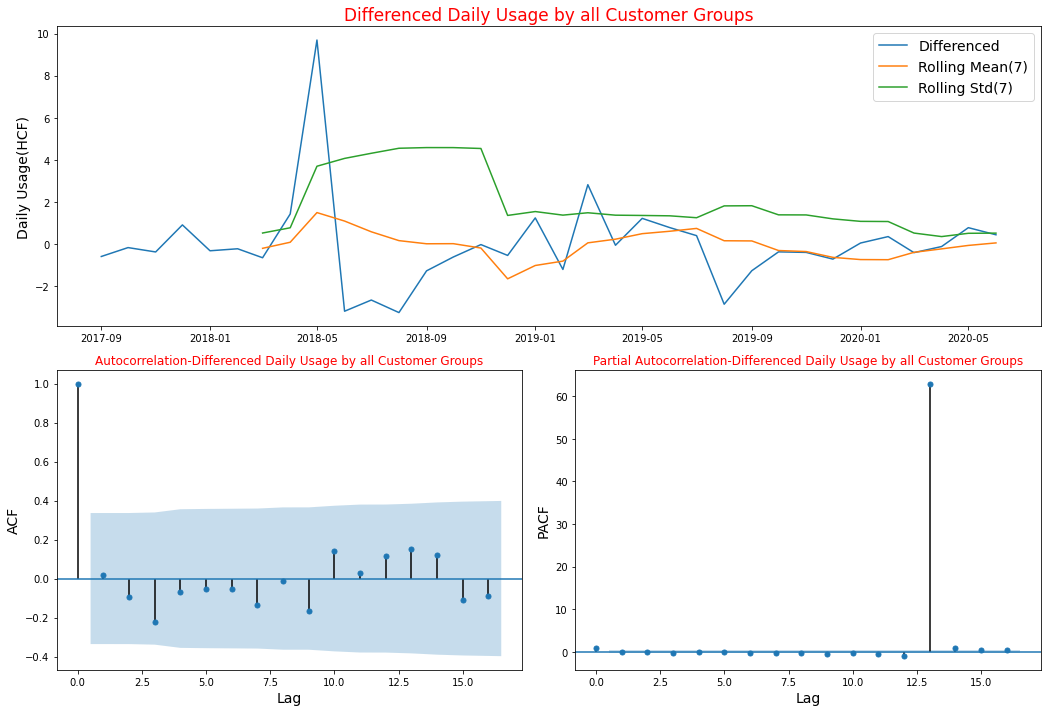

In [78]:
#Plot ACF and PACF for differenced daily usage 
check_stationary_differenced(diff1_usage, 'Differenced Daily Usage by all Customer Groups')

In [79]:
pd.set_option('display.max_colwidth', -1)

np.warnings.filterwarnings('ignore')
result_all = pd.DataFrame()

#SES
params, metrics = SES(ts_usage)
result_all = result_all.append(['Simple Exponential Smoothing', 'α={}'.format(params)]\
                               +[x for x in metrics]).T
result_all.columns = ['Model','Params', 'RMSE','MAE','MAPE','R2']


#HWES
params, metrics = HWES_model(ts_usage)
result_all = result_all.append(pd.Series(['Exponential Smoothing']+ ['α: {}, β: {}, γ: {}, ϕ: {}'\
                               .format(params[0], params[1], params[2], params[3])]\
                              +[x for x in metrics], index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)


#Autoregressive
min_AIC_param_all , min_BIC_param_all = evaluate_AR_model(diff1_usage)
result_all = result_all.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_AIC: {}'.format(min_AIC_param_all['p'].item(),min_AIC_param_all['trend'].item()\
              ,min_AIC_param_all['seasonal'].item() , min_AIC_param_all['AIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_usage, min_AIC_param_all['p'].item(),\
                                            min_AIC_param_all['trend'].item(), min_AIC_param_all['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_all = result_all.append(pd.Series(['Auto Regressive']\
            +['p: {}, trend: {}, seasonal: {}, min_BIC: {}'.format(min_BIC_param_all['p'].item(), min_BIC_param_all['trend'].item()\
              , min_BIC_param_all['seasonal'].item(), min_BIC_param_all['BIC'].round(2).item())]\
                                         +[x for x in optimal_AR(diff1_usage, min_BIC_param_all['p'].item(),\
                                            min_BIC_param_all['trend'].item(), min_BIC_param_all['seasonal'].item())],\
                                         index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

#Moving Average
min_AIC_param_all , min_BIC_param_all = evaluate_MA_models(diff1_usage)

result_all = result_all.append(pd.Series(
      ['Moving Avg','q: {}, min_AIC: {}'.format(min_AIC_param_all['(0,q)'].item()[1], min_AIC_param_all['AIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_usage, min_AIC_param_all['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_all = result_all.append(pd.Series(
    ['Moving Avg','q: {}, min_BIC: {}'.format(min_BIC_param_all['(0,q)'].item()[1], min_BIC_param_all['BIC'].round(2).item())]\
                              +[x for x in optimal_MA(diff1_usage, min_BIC_param_all['(0,q)'].item())],\
                              index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#Auto Regressive Moving Average
min_AIC_param_all , min_BIC_param_all = evaluate_arma_models(diff1_usage)

result_all = result_all.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_AIC: {}'.format(min_AIC_param_all['(p,q)'].item(), min_AIC_param_all['AIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_usage, min_AIC_param_all['(p,q)'].item())],\
                                          index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)

result_all = result_all.append(pd.Series(
    ['AutoRegressive MovingAvg','(p,q): {}, min_BIC: {}'.format(min_BIC_param_all['(p,q)'].item(), min_BIC_param_all['BIC'].round(2).item())]\
                                         + [x for x in optimal_arma(diff1_usage, min_BIC_param_all['(p,q)'].item())],\
                                        index= ['Model','Params','RMSE','MAE','MAPE','R2']),ignore_index=True)





#ARIMA
min_AIC_param_all , min_BIC_param_all = evaluate_arima_models(diff1_usage)
result_all = result_all.append(pd.Series(
    ['ARIMA', '(p,d,q): {}, min_AIC: {}'.format(min_AIC_param_all['(p,d,q)'].item(), min_AIC_param_all['AIC'].round(2).item())]\
                  + [x for x in optimal_arima(diff1_usage, min_AIC_param_all['(p,d,q)'].item())],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result_all = result_all.append(pd.Series(
    ['ARIMA','(p,d,q): {}, min_BIC: {}'.format(min_BIC_param_all['(p,d,q)'].item(), min_AIC_param_all['BIC'].round(2).item() )]\
                   + [x for x in optimal_arima(diff1_usage, min_BIC_param_all['(p,d,q)'].item())],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)



#SARIMA
min_AIC_param_all , min_BIC_param_all = evaluate_SARIMAX_model(diff1_usage)
result_all = result_all.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_AIC: {}'\
             .format(min_AIC_param_all['trend'].item(), min_AIC_param_all['(p,d,q)'].item(), min_AIC_param_all['(P,D,Q,m)'].item()\
                     , min_AIC_param_all['AIC'].round(2).item())]\
                  + [x for x in optimal_sarima(diff1_usage, min_AIC_param_all)],\
                                          index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)

result_all = result_all.append(pd.Series(['SARIMAX', 'trend: {}, (p,d,q): {}, (P,D,Q,m): {}, min_BIC: {}'\
       .format(min_BIC_param_all['trend'].item(), min_BIC_param_all['(p,d,q)'].item(), min_AIC_param_all['(P,D,Q,m)'].item()\
               , min_AIC_param_all['BIC'].round(2).item() )]\
                   + [x for x in optimal_sarima(diff1_usage, min_BIC_param_all)],\
                                        index= ['Model','Params', 'RMSE','MAE','MAPE','R2']),ignore_index=True)





result_all

,Model,Params,RMSE,MAE,MAPE,R2
0,Simple Exponential Smoothing,α=1.0,0.481,0.409,13.3,0.16
1,Exponential Smoothing,"α: 1.0, β: nan, γ: nan, ϕ: nan",0.481,0.409,13.3,0.16
2,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_AIC: -0.24",0.799,0.694,372.5,-0.46
3,Auto Regressive,"p: 3, trend: ct, seasonal: False, min_BIC: 0.01",0.799,0.694,372.5,-0.46
4,Moving Avg,"q: 0, min_AIC: 148.22",0.496,0.422,119.68,-0.27
5,Moving Avg,"q: 0, min_BIC: 151.21",0.496,0.422,119.68,-0.27
6,AutoRegressive MovingAvg,"(p,q): (2, 1), min_AIC: 148.22",0.824,0.687,409.59,-0.45
7,AutoRegressive MovingAvg,"(p,q): (0, 0), min_BIC: 151.21",0.496,0.422,119.68,-0.27
8,ARIMA,"(p,d,q): (2, 0, 1), min_AIC: 148.22",0.824,0.687,409.59,-0.45
9,ARIMA,"(p,d,q): (0, 0, 0), min_BIC: 155.7",0.496,0.422,119.68,-0.27
